# Analysis of the Ethereum Blockchain Liquidations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.size'] = 22

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [2]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Liquidation Analysis

## Data Loading and Preprocessing

In [3]:
AFTER_BLOCK = 15600000
BEFORE_BLOCK = 15900000

In [4]:
query = f"SELECT * FROM liquidations WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
liquidation_df = pd.DataFrame(conn.execute(text(query)))

In [5]:
liquidation_df.set_index('id', inplace=True)
liquidation_df['timestamp'] = pd.to_datetime(liquidation_df['timestamp'])
liquidation_df = liquidation_df.sort_values(by=['block_number', 'block_position'])

In [6]:
liquidation_df.head()

,transaction_hash,block_number,timestamp,trace_address,status,liquidated_user,liquidator_user,debt_token_address,debt_purchase_amount,received_amount,received_token_address,protocol,gas_price,gas_usage,block_position
id,,,,,,,,,,,,,,,
19,0x1741fa81f32954cc6385781da56fcbfaae8839959753...,15200838,2022-07-24 00:11:11,"{2,1,5}",True,0xcc603bec12aa268780cde4b852b1440ee7cf6b8b,0x8472ee188899569cf6ef42bb2038facae66972d2,0xdac17f958d2ee523a2206206994597c13d831ec7,123168435,86526557700677640,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,aave,2480101,488412,7
20,0x9f7b435bee2c2610c168d3f07351adeb4b8fba1c4b03...,15200853,2022-07-24 00:14:38,"{0,2,1}",True,0xaa9a8252421f801259e342f816f079e9e2d540fd,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,0xdac17f958d2ee523a2206206994597c13d831ec7,117923209,82841755258054296,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,aave,669628,502222,3
21,0x83ff1b8360c9ecf7f5e6aef01d02964132d81d53764d...,15200860,2022-07-24 00:15:13,"{0,2,2}",True,0x2e5b27a6ee216c90f6f42bfeadd7cd25888e5be3,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,0xdac17f958d2ee523a2206206994597c13d831ec7,72904649,261109595,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,compound_v2,693456,403409,1
22,0xd8d72681356931e895f555ff34fca07460f9360e0f4b...,15200873,2022-07-24 00:17:29,"{2,1,5}",True,0xf8b11cc89f0a12ddfa163865eeb168791aa03912,0x8472ee188899569cf6ef42bb2038facae66972d2,0xdac17f958d2ee523a2206206994597c13d831ec7,137103234,22047935724083990666,0x514910771af9ca656af840dff83e8264ecf986ca,aave,3287587,605587,15
23,0xf828ee8a42b88a352f65f41698f77718e9e07c1e27aa...,15200873,2022-07-24 00:17:29,"{0,2,2}",True,0x334ca9fa33b2560a0fc6cdb2e5b95a28ea3005ed,0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,91220273,445905,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,aave,2546646,483353,16


In [47]:
liquidation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677 entries, 1860 to 2536
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_hash        677 non-null    object        
 1   block_number            677 non-null    int64         
 2   timestamp               677 non-null    datetime64[ns]
 3   trace_address           677 non-null    object        
 4   status                  677 non-null    bool          
 5   liquidated_user         677 non-null    object        
 6   liquidator_user         677 non-null    object        
 7   debt_token_address      677 non-null    object        
 8   debt_purchase_amount    677 non-null    object        
 9   received_amount         677 non-null    object        
 10  received_token_address  677 non-null    object        
 11  protocol                677 non-null    object        
 12  gas_price               677 non-null    int64 

## Status Analysis

Get the success rate of each liquidator and protocol.

In [48]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [49]:
liquidator_success_rate = liquidation_df.groupby('liquidator_user')['status'].mean()
print('Success rate of each address:')
liquidator_success_rate.head()

Success rate of each address:


liquidator_user
0x00000000008ace292e5c274be46d30116fab4ee2    1.0
0x0132d1860cf0f1e5e805c23a4e8309ecee23c1dc    1.0
0x04c3256c1328b5d685916de07bb1f721b06b966a    1.0
0x09d5dad5a97e0431b974b211fc0082efb172cab7    1.0
0x170567524b6906c44563b0fe0a027f5d1ddd115f    1.0
Name: status, dtype: float64

### By Protocol
Get the success rate of each protocol


In [50]:
protocols_df = liquidation_df["protocol"].str.get_dummies()

# Concatenate the status column and the protocol columns
merged_df = pd.concat([liquidation_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

aave           0.49483
compound_v2    0.50517
dtype: float64

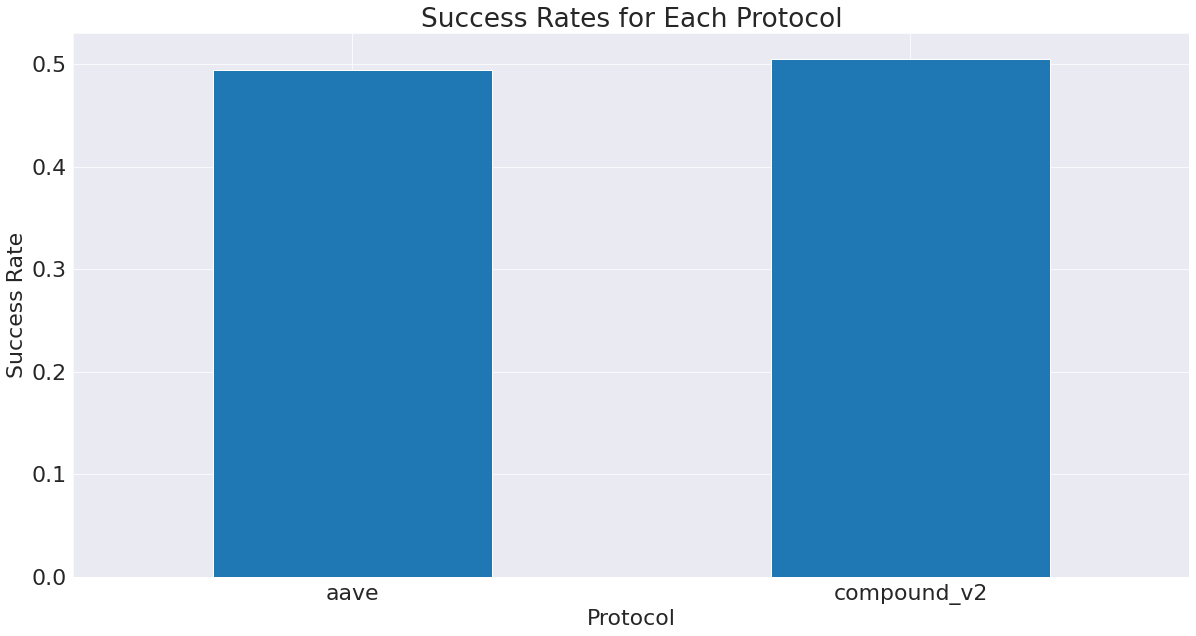

In [51]:
plt.figure(figsize=(20, 10))
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution

### Average gas usage per block
Compare average gas price for liquidation transactions in each block with the total average gas price of that block.

First, load the blocks' data.

In [52]:
# TODO: Log-transformation for heavy-tailed features
query = f"SELECT * FROM blocks WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df = block_df.sort_values(by=['block_number'])
block_df

,block_number,avg_gas_price,avg_gas_usage
0,15600000,9.784476e+09,157081.127907
1,15600001,9.313270e+09,108637.623853
2,15600002,9.849113e+09,272353.550725
3,15600003,9.025566e+09,154485.951807
4,15600004,9.780545e+09,149676.708955
...,...,...,...
299995,15899995,1.653963e+10,180300.406504
299996,15899996,1.404016e+10,204445.519380
299997,15899997,1.337028e+10,176342.420732
299998,15899998,1.300481e+10,188917.658228


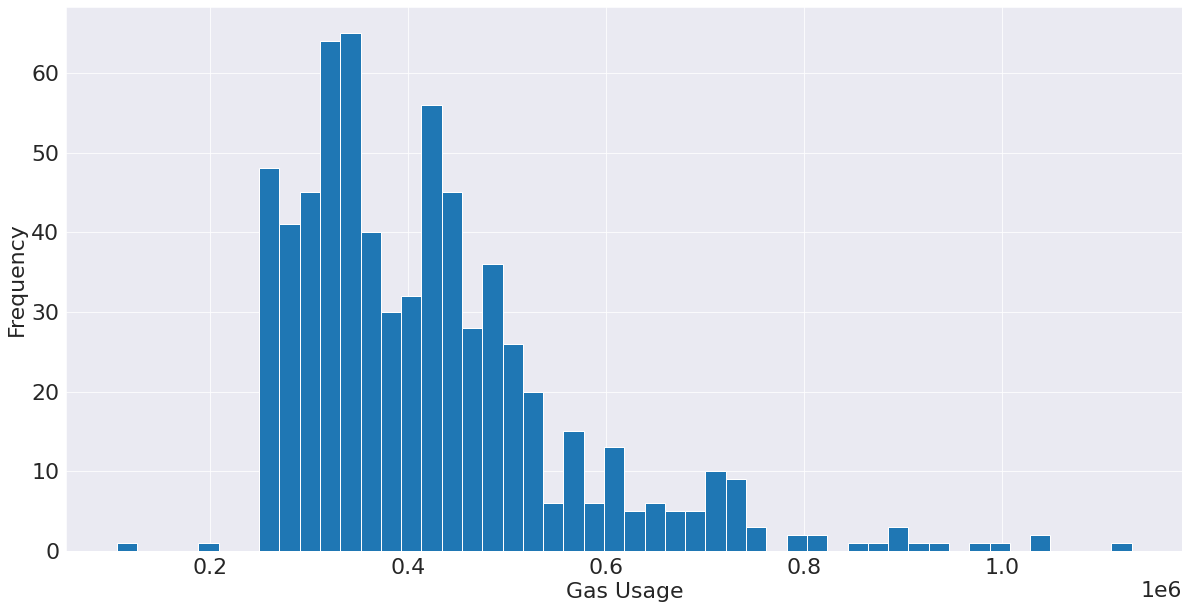

In [53]:
# Gas usage distribution

plt.figure(figsize=(20, 10))
plt.hist(liquidation_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [54]:
avg_gas_per_block = liquidation_df.groupby('block_number')['gas_usage'].mean()

In [55]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
0,15601267,5.886363e+09,240974.589404,435063.0
1,15601273,5.743630e+09,98107.777778,433771.0
2,15601275,6.650361e+09,191041.168421,435063.0
3,15601284,2.349737e+10,190901.375839,405914.0
4,15601418,5.717983e+09,139044.525641,321046.0
...,...,...,...,...
380,15895604,1.674937e+10,221472.129730,599736.0
381,15895611,2.732177e+10,194930.937500,584681.0
382,15896892,4.413194e+10,311016.532787,513164.0
383,15897217,4.245338e+10,332857.497326,321905.0


,block_number,avg_gas_price,avg_gas_usage,gas_usage
0,15601267,5.886363e+09,240974.589404,435063.0
1,15601273,5.743630e+09,98107.777778,433771.0
2,15601275,6.650361e+09,191041.168421,435063.0
3,15601284,2.349737e+10,190901.375839,405914.0
4,15601418,5.717983e+09,139044.525641,321046.0
...,...,...,...,...
380,15895604,1.674937e+10,221472.129730,599736.0
381,15895611,2.732177e+10,194930.937500,584681.0
382,15896892,4.413194e+10,311016.532787,513164.0
383,15897217,4.245338e+10,332857.497326,321905.0


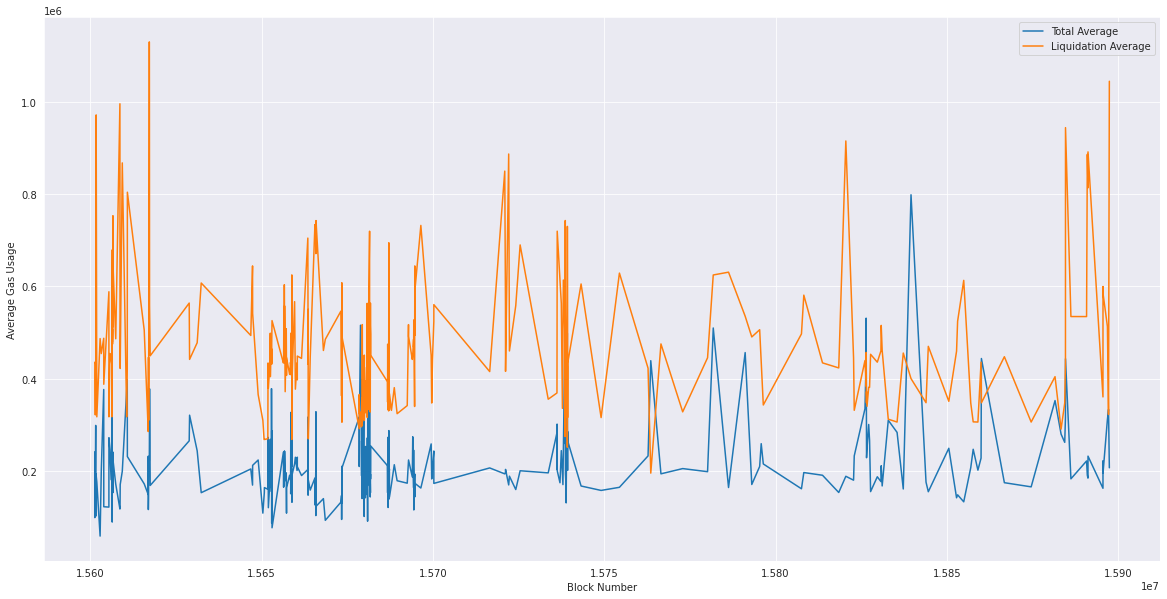

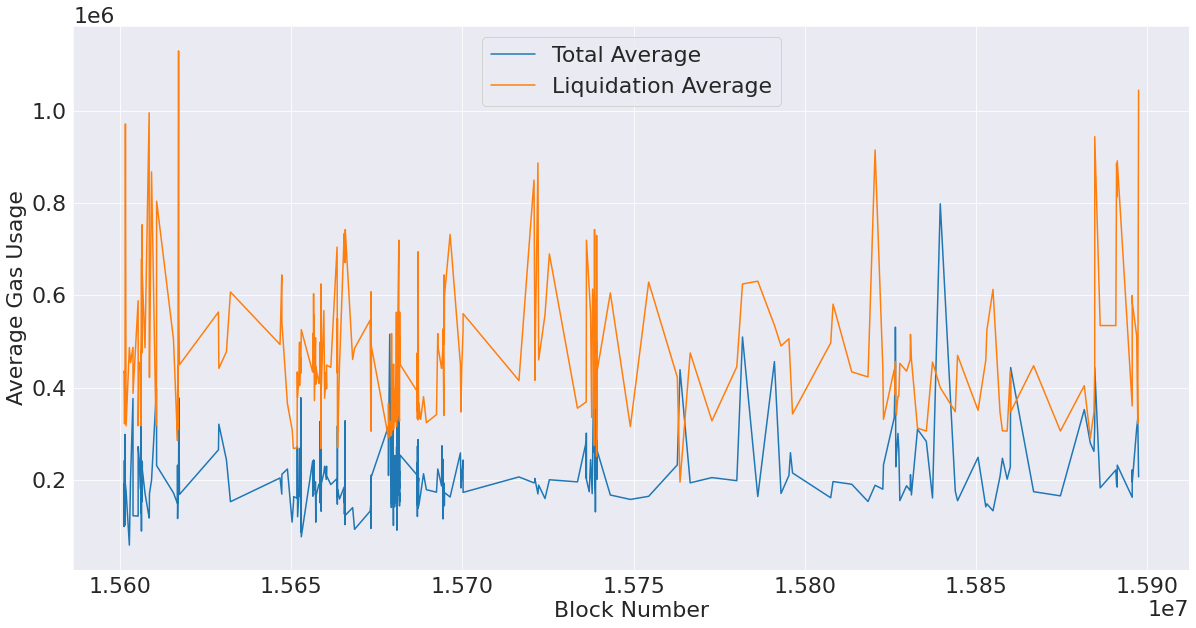

In [56]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(20, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Liquidation Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

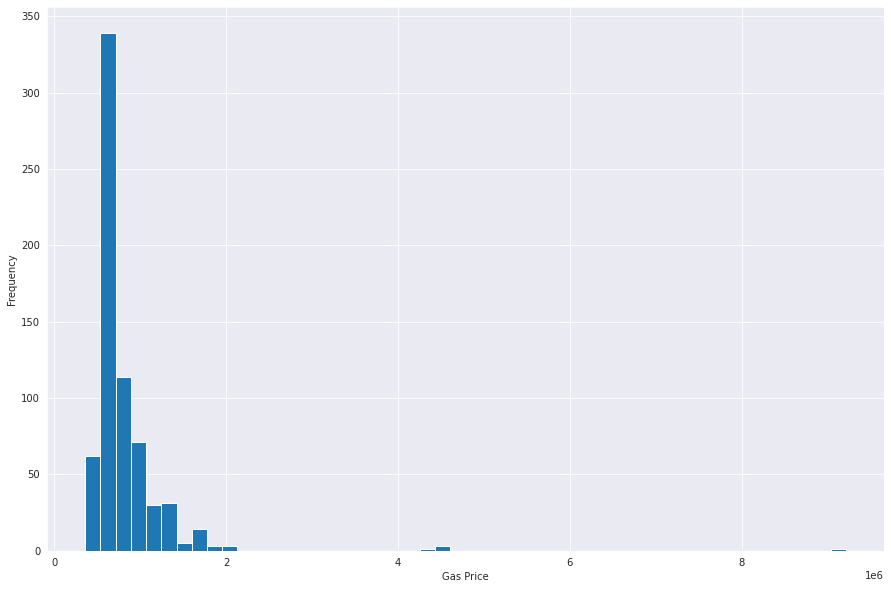

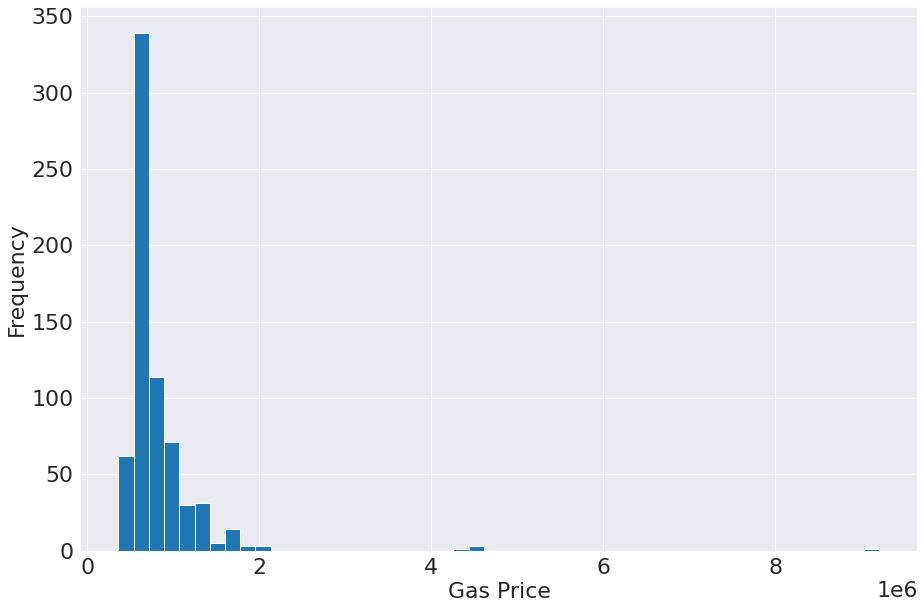

In [57]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(liquidation_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

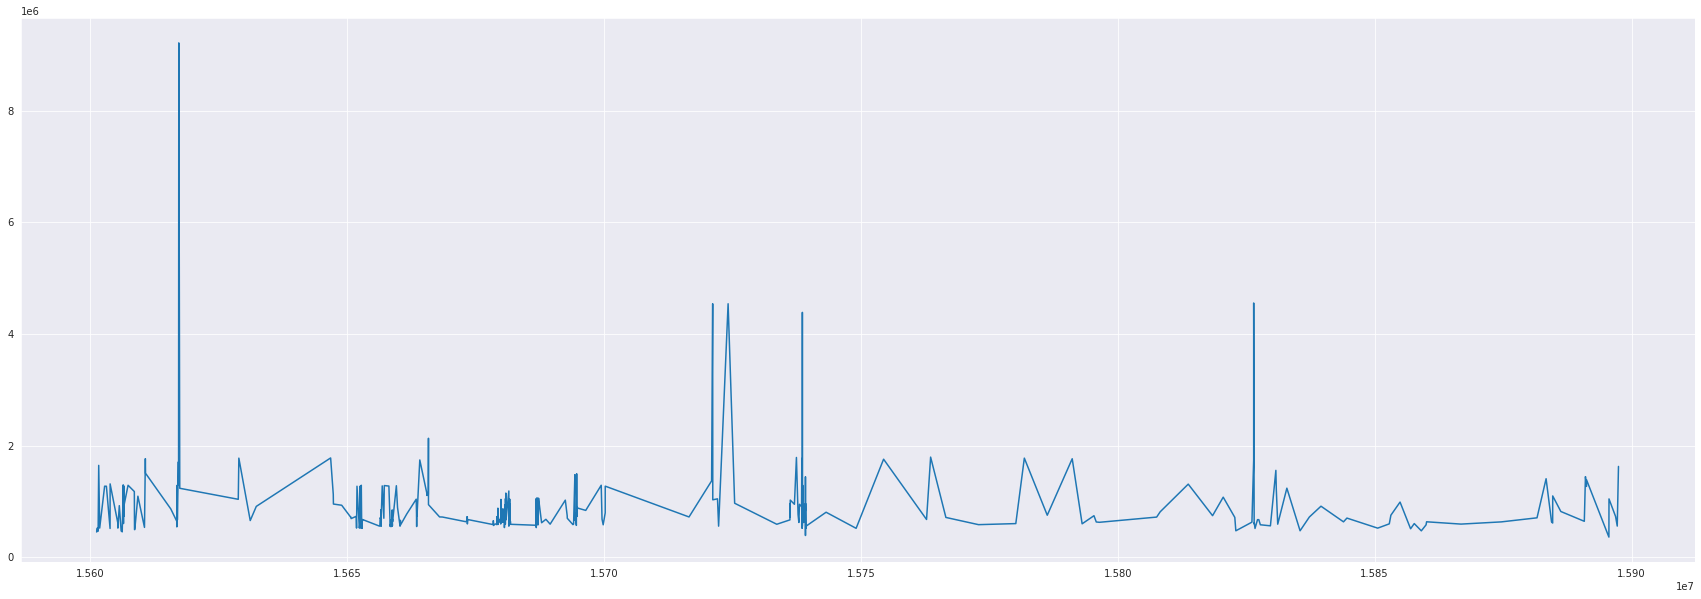

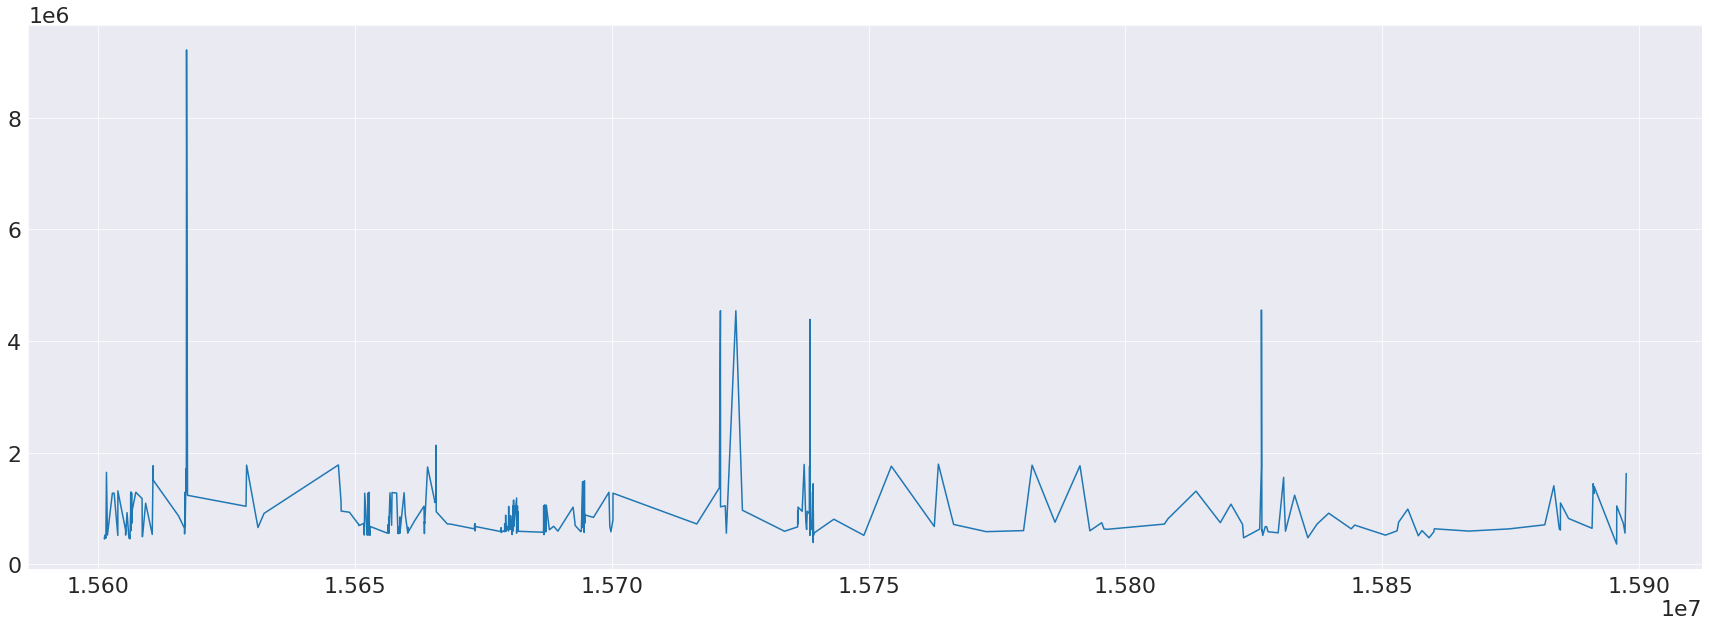

In [58]:
avg_gas_per_block = liquidation_df.groupby('block_number')['gas_price'].mean()
# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Liquidation Average')
plt.show()

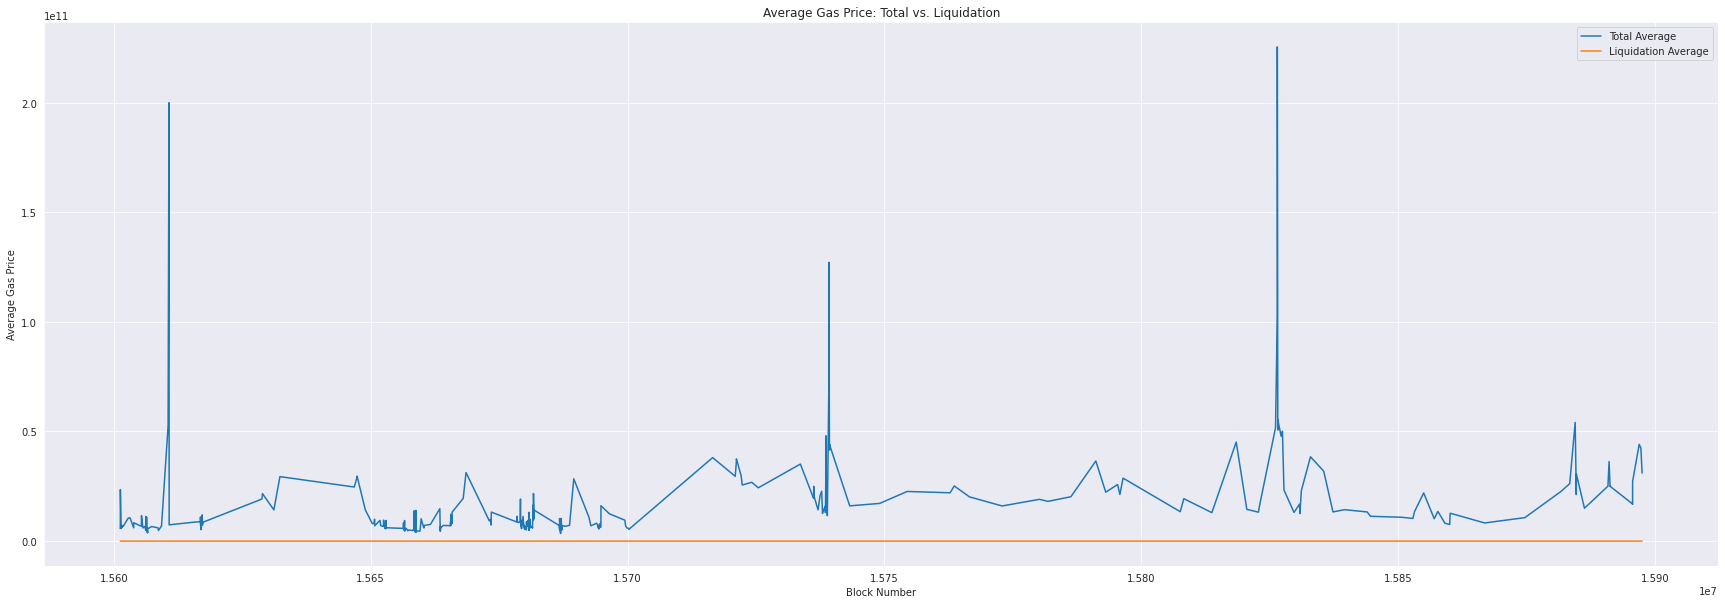

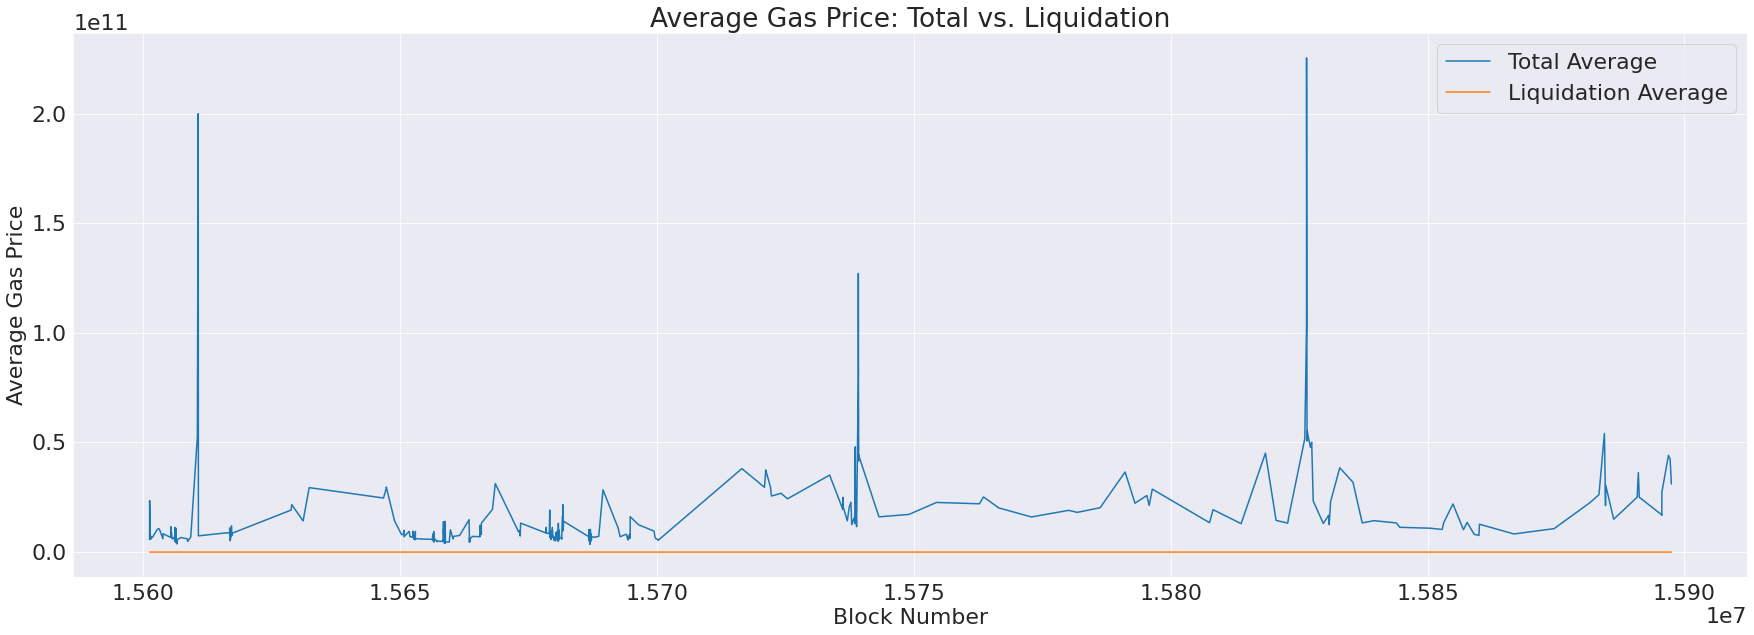

In [59]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Liquidation Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.title("Average Gas Price: Total vs. Liquidation")
plt.legend()
plt.show()

# Analysis of the Tokens

In [60]:
from collections import Counter


def _address_use(token_column: str):
    all_sets = pd.concat([liquidation_df[token_column]])
    all_strings = [string for set_ in all_sets for string in set_.split(',')]
    counts = Counter(all_strings)

    return pd.DataFrame(counts.values(), index=counts.keys(), columns=['count'])

In [61]:
debt_tokens = _address_use('debt_token_address')
received_tokens = _address_use('received_token_address')

In [62]:
from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [63]:
def plot_tokens_usage(tokens, _type):
    most_used_tokens = tokens.nlargest(10, tokens.columns[0])
    token_name_tags = _get_name_tags(most_used_tokens.index)

    x = most_used_tokens.index.map(token_name_tags)

    plt_fig, _ax = plt.subplots(figsize=(20, 10))
    _ax.bar(x, most_used_tokens.values.squeeze(), width=0.4)
    _ax.set_xticks(x)
    _ax.set_xticklabels(x, rotation=60, ha='right')

    _ax.set_title(f"Most used {_type} tokens for liquidation")

    _ax.set_xlabel("token public name tag")
    _ax.set_ylabel('number of liquidations', labelpad=15)

    plt.show()

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: TokenMintERC20Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Basic Attention: BAT Token
INFO:root:Already found: 1inch Network: 1INCH Token
INFO:root:Already found: TrueUSD: TUSD Token


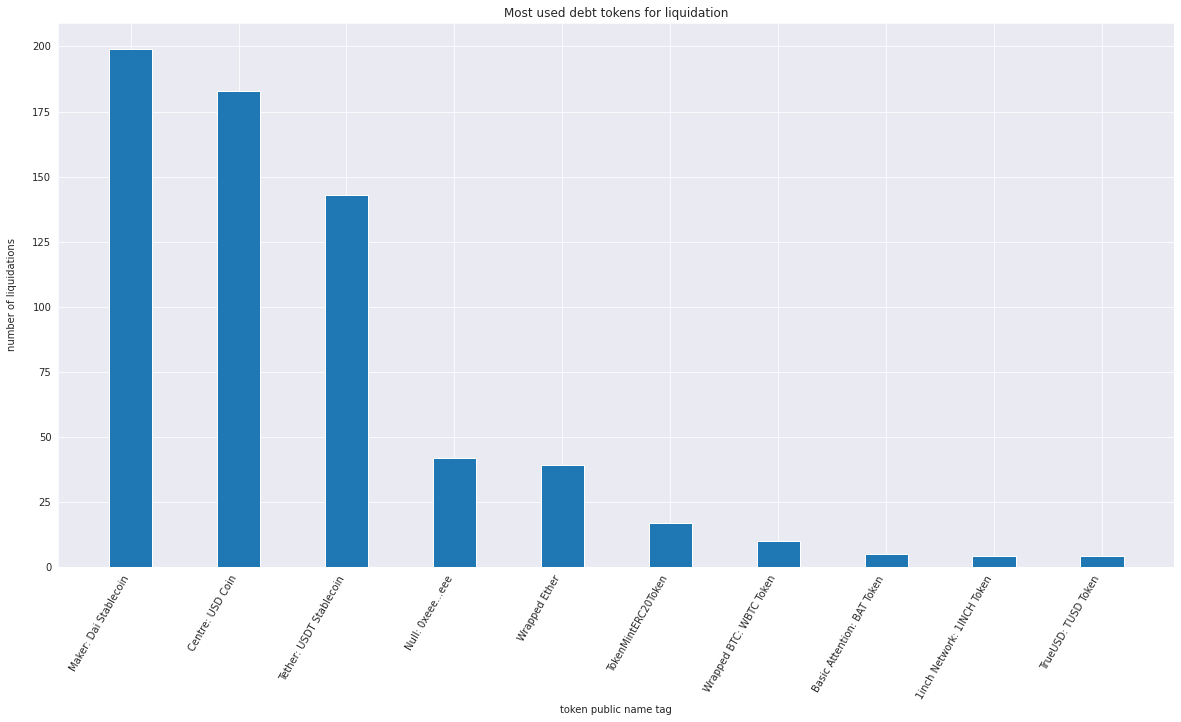

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: TokenMintERC20Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Basic Attention: BAT Token
INFO:root:Already found: 1inch Network: 1INCH Token
INFO:root:Already found: TrueUSD: TUSD Token


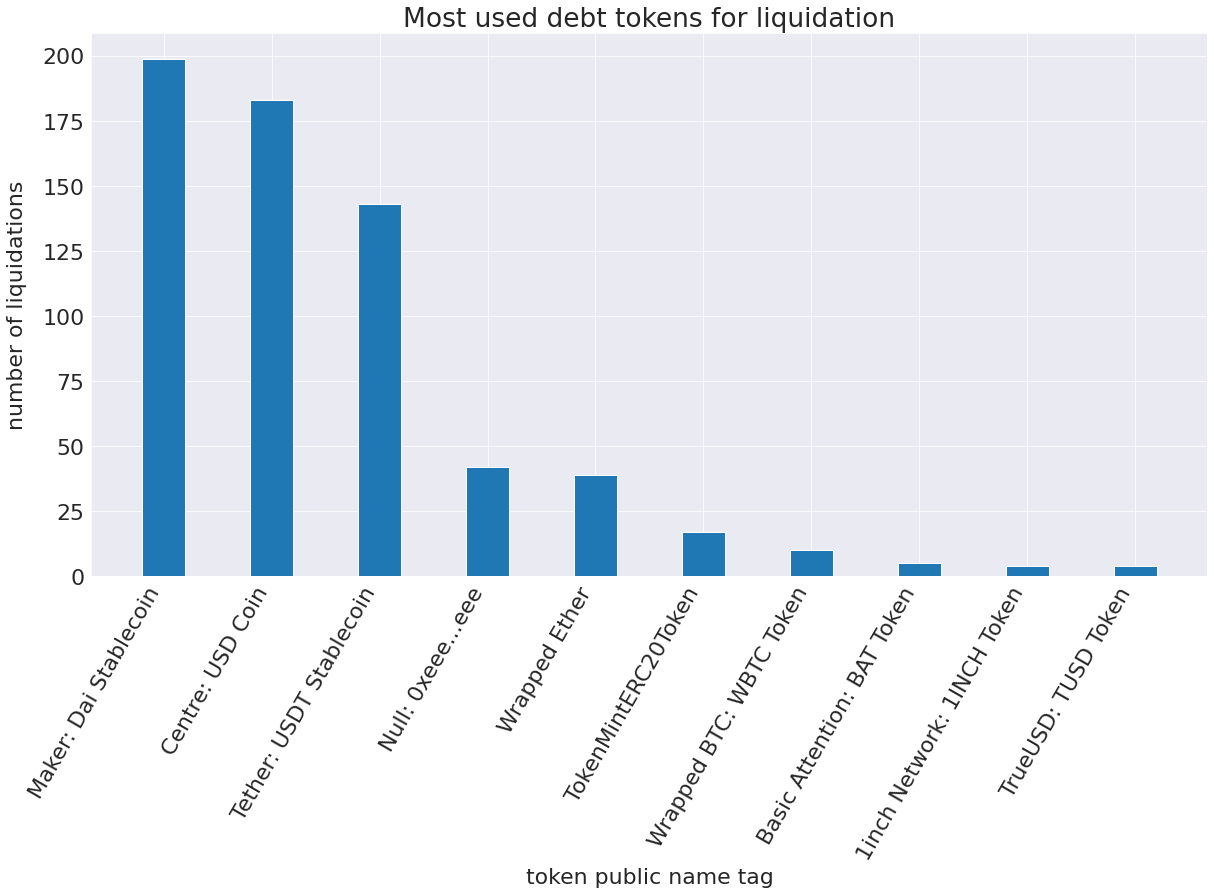

In [64]:
plot_tokens_usage(debt_tokens, "debt")

INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Aave: aWETH Token V2
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Aave: aAAVE Token V2
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Compound: cUSDC Token
INFO:root:Already found: Aave: aLINK Token V2
INFO:root:Already found: Compound: cBAT Token
INFO:root:Already found: Compound: cZRX Token


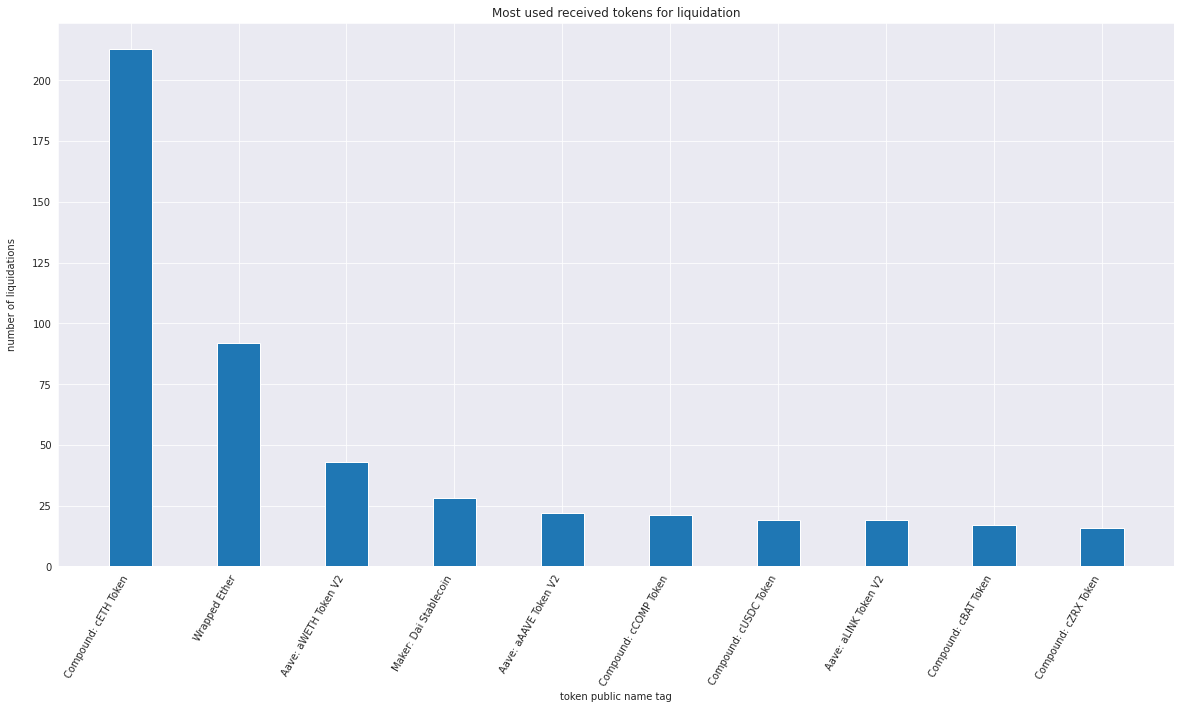

INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Aave: aWETH Token V2
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Aave: aAAVE Token V2
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Compound: cUSDC Token
INFO:root:Already found: Aave: aLINK Token V2
INFO:root:Already found: Compound: cBAT Token
INFO:root:Already found: Compound: cZRX Token


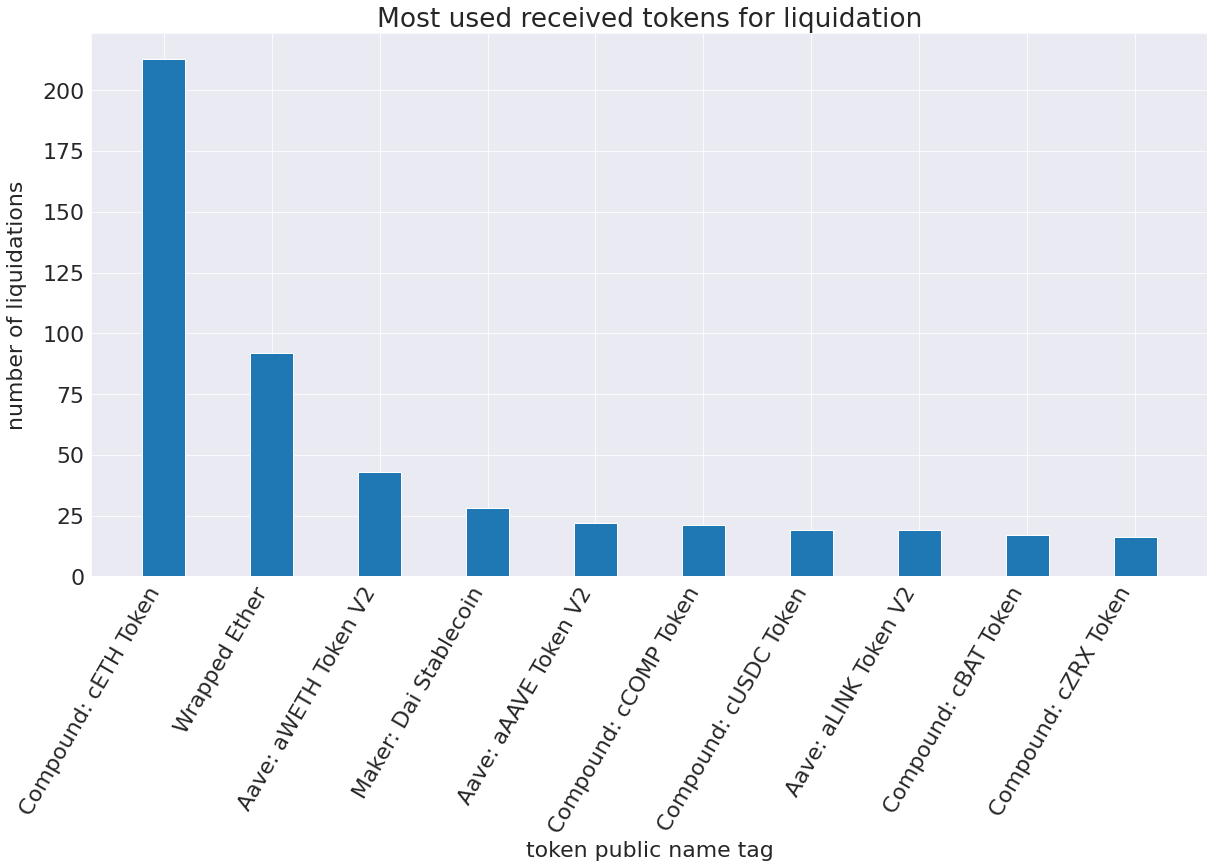

In [65]:
plot_tokens_usage(received_tokens, "received")

## Active Addresses Analysis

### Most Active Addresses

In this part we take a look at the most active liquidators i.e. the addresses that have the largest number of liquidation transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of transactions and profit.

The distribution of the number of transactions by address

INFO:root:Already found: MEV Bot: 0xD91...C6F
INFO:root:Already found: Contract Address 0x807c7f4a42530224d0cf58bb5aea0a3a23591f64
INFO:root:Already found: MEV Bot: 0x9A0...832
INFO:root:Already found: Contract Address 0xb206ebe579be55f5b57119bb2e7cc63708eda1aa
INFO:root:Already found: Contract Address 0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8
INFO:root:Already found: Contract Address 0x170567524b6906c44563b0fe0a027f5d1ddd115f
INFO:root:Already found: Contract Address 0x43ecc783cb63ef11e11eb9a896db2d6a814e0c32
INFO:root:Already found: fuxktheworld.eth
INFO:root:Already found: Contract Address 0x581128be1afe0b0ebed3881dadc491f179d21274
INFO:root:Already found: MEV Bot: 0x6C6...64e


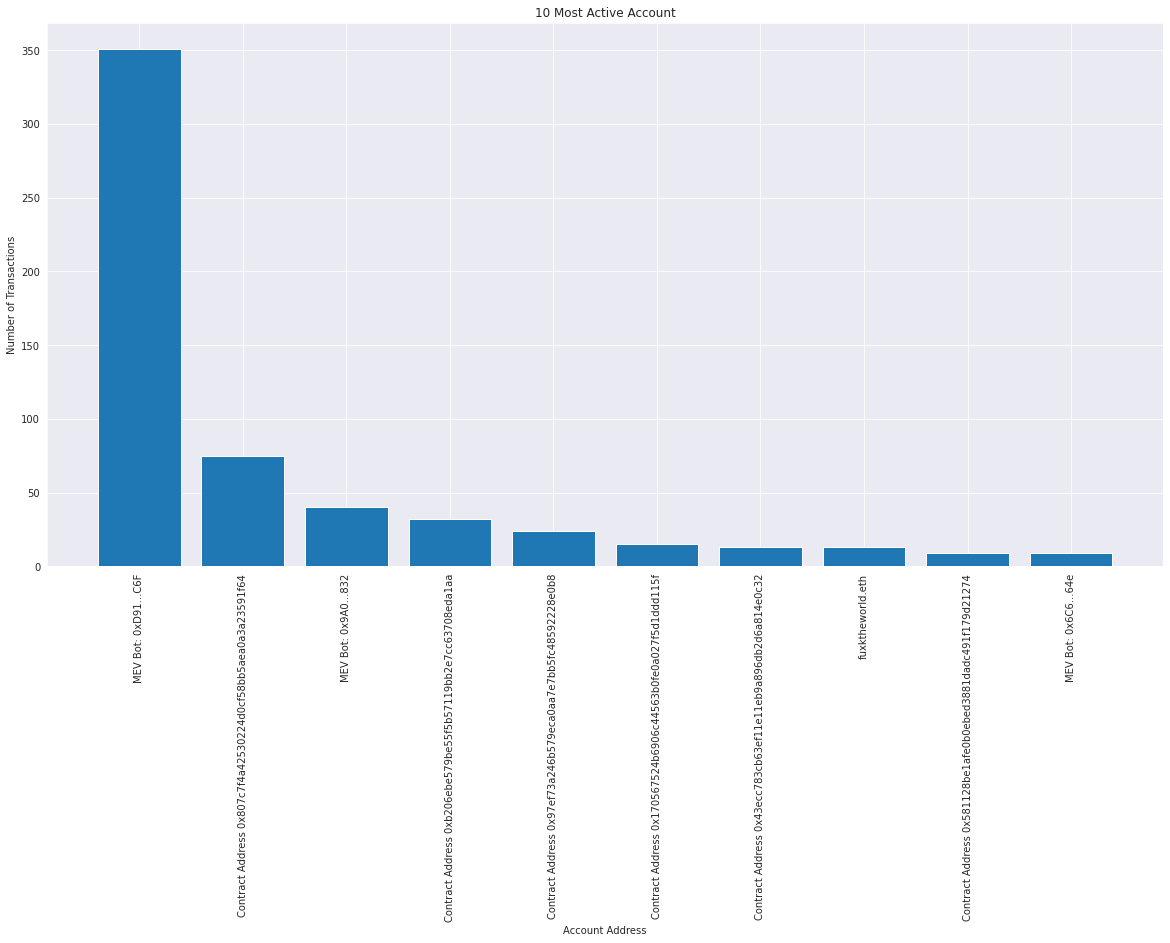

INFO:root:Already found: MEV Bot: 0xD91...C6F
INFO:root:Already found: Contract Address 0x807c7f4a42530224d0cf58bb5aea0a3a23591f64
INFO:root:Already found: MEV Bot: 0x9A0...832
INFO:root:Already found: Contract Address 0xb206ebe579be55f5b57119bb2e7cc63708eda1aa
INFO:root:Already found: Contract Address 0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8
INFO:root:Already found: Contract Address 0x170567524b6906c44563b0fe0a027f5d1ddd115f
INFO:root:Already found: Contract Address 0x43ecc783cb63ef11e11eb9a896db2d6a814e0c32
INFO:root:Already found: fuxktheworld.eth
INFO:root:Already found: Contract Address 0x581128be1afe0b0ebed3881dadc491f179d21274
INFO:root:Already found: MEV Bot: 0x6C6...64e


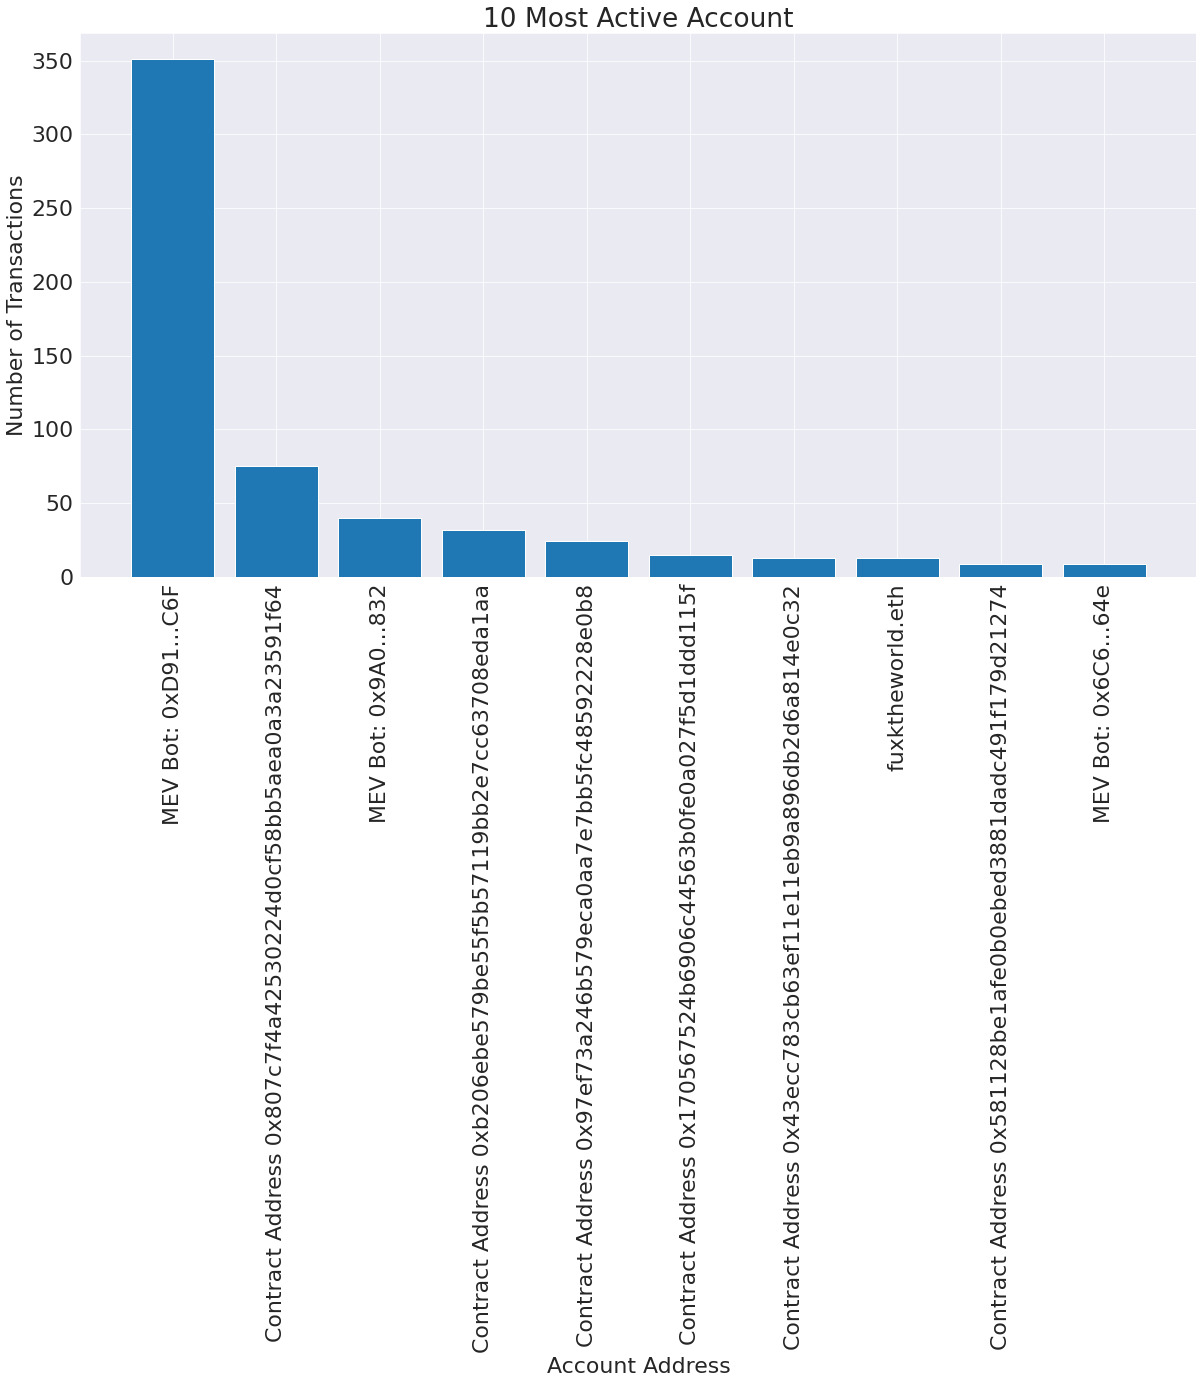

In [66]:
# Count the number of transactions for each account address
transactions_by_address = liquidation_df['liquidator_user'].value_counts()
account_name_tags = _get_name_tags(transactions_by_address.head(10).index)

# Plot the results as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(transactions_by_address.head(10).index.map(account_name_tags), transactions_by_address.head(10))
plt.title('10 Most Active Account')
plt.xlabel('Account Address')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.show()

### Distribution

The distribution of the number of transactions per address.

Note: Addresses with less than 5 transactions were removed. There were around 300 accounts.

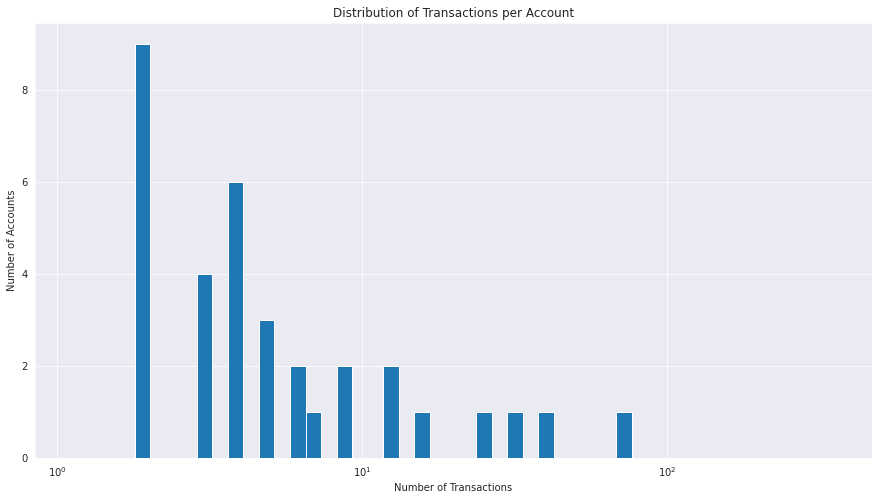

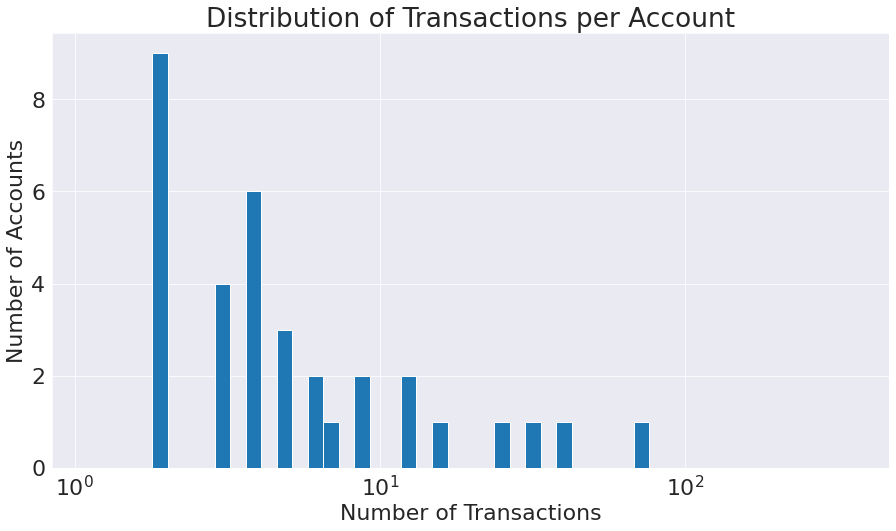

In [67]:
# Group by account address and count the number of transactions
transactions_per_account = liquidation_df.groupby(['liquidator_user']).size()

# Define custom bin edges
bin_edges = np.logspace(np.log10(1), np.log10(transactions_per_account.max()), 51)

# Remove the first bin edge
bin_edges = bin_edges[1:]

# Plot the distribution of transactions per account as a histogram
plt.figure(figsize=(15, 8))
plt.hist(transactions_per_account, bins=bin_edges)
plt.xscale('log')
plt.title('Distribution of Transactions per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.show()

## Ratio of arbitrage transactions

What's the ratio of arbitrage transactions to all transactions for the top 20 addresses?

In [68]:
top_addresses = transactions_by_address.head(20)
top_addresses

0xd911560979b78821d7b045c79e36e9cbfc2f6c6f    351
0x807c7f4a42530224d0cf58bb5aea0a3a23591f64     75
0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832     40
0xb206ebe579be55f5b57119bb2e7cc63708eda1aa     32
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8     24
0x170567524b6906c44563b0fe0a027f5d1ddd115f     15
0x43ecc783cb63ef11e11eb9a896db2d6a814e0c32     13
0x4a10b1e56109ecebd9e3d823bf47e7e88ebf3cae     13
0x581128be1afe0b0ebed3881dadc491f179d21274      9
0x6c6b87d44d239b3750bf9badce26a9a0a3d2364e      9
0x23d4e89d807ac63efe0e013c5f39f2a93028e4e5      7
0xcda3d75a1a247bf3fa9efd0727db54d7cf0c90c2      6
0xe029873c18b994af1979203e142690747dd12855      6
0xc2a54f74ebbbba5ed92d6a0b5dcb0b0ffb96f36e      5
0x886c98550d0ef59bfa9fc45a2268d2bd71582776      5
0x09d5dad5a97e0431b974b211fc0082efb172cab7      5
0xe3b9ed955bf1c8c520bb9420abac6e62bb110b29      4
0x31d2608997711a125dc111206687f97d60c543c8      4
0xacfa0ec35b6e652a0904c9617823cb77b88230d6      4
0xcac7b1db0bfb408725bfe644bdf04537d7b567a3      4


0xd911560979b78821d7b045c79e36e9cbfc2f6c6f    351
0x807c7f4a42530224d0cf58bb5aea0a3a23591f64     75
0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832     40
0xb206ebe579be55f5b57119bb2e7cc63708eda1aa     32
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8     24
0x170567524b6906c44563b0fe0a027f5d1ddd115f     15
0x43ecc783cb63ef11e11eb9a896db2d6a814e0c32     13
0x4a10b1e56109ecebd9e3d823bf47e7e88ebf3cae     13
0x581128be1afe0b0ebed3881dadc491f179d21274      9
0x6c6b87d44d239b3750bf9badce26a9a0a3d2364e      9
0x23d4e89d807ac63efe0e013c5f39f2a93028e4e5      7
0xcda3d75a1a247bf3fa9efd0727db54d7cf0c90c2      6
0xe029873c18b994af1979203e142690747dd12855      6
0xc2a54f74ebbbba5ed92d6a0b5dcb0b0ffb96f36e      5
0x886c98550d0ef59bfa9fc45a2268d2bd71582776      5
0x09d5dad5a97e0431b974b211fc0082efb172cab7      5
0xe3b9ed955bf1c8c520bb9420abac6e62bb110b29      4
0x31d2608997711a125dc111206687f97d60c543c8      4
0xacfa0ec35b6e652a0904c9617823cb77b88230d6      4
0xcac7b1db0bfb408725bfe644bdf04537d7b567a3      4


## Time-Series Analysis of Arbitrage Transactions

In [69]:
timed_arb_df = liquidation_df.set_index('timestamp', inplace=False)

daily_arb = timed_arb_df.resample('D')

In [70]:
daily_summary = daily_arb.agg({
    'transaction_hash': 'count',
    'block_number': ['min', 'max'],
    'liquidator_user': pd.Series.nunique,
    'liquidated_user': pd.Series.nunique,
    'status': 'sum',
    'gas_price': ['min', 'max', 'mean', 'sum'],
    'gas_usage':  ['min', 'max', 'mean', 'sum'],
    'block_position': ['min', 'max', 'mean'],
    'debt_purchase_amount': ['min', 'max', 'mean', 'sum'],
    'received_amount': ['min', 'max', 'mean', 'sum']
})

daily_summary

transaction_hash block_number             liquidator_user  \
                      count          min         max         nunique   
timestamp                                                              
2022-09-24               18   15601267.0  15605394.0               4   
2022-09-25               28   15605673.0  15610776.0               7   
2022-09-26               12   15615693.0  15617441.0               6   
2022-09-27                0          NaN         NaN               0   
2022-09-28                4   15628826.0  15632336.0               4   
2022-09-29                0          NaN         NaN               0   
2022-09-30                3   15646804.0  15647346.0               2   
2022-10-01               22   15648958.0  15653009.0               4   
2022-10-02               52   15656325.0  15661622.0               9   
2022-10-03               26   15663461.0  15668561.0               7   
2022-10-04               12   15673107.0  15673486.0               4   
2022-10-05              301   15678467.0  15681830.0               5   
2022-10-06               68   15686712.0  15689527.0               5   
2022-10-07               15   15692480.0  15696455.0               6   
2022-10-08                5   15699467.0  15700247.0               3   
2022-10-09                0          NaN         NaN               0   
2022-10-10                1   15716556.0  15716556.0               1   
2022-10-11                7   15720952.0  15725439.0               4   
2022-10-12                1   15733635.0  15733635.0               1   
2022-10-13               32   15736194.0  15739338.0              14   
2022-10-14                1   15743235.0  15743235.0               1   
2022-10-15                2   15749079.0  15754426.0               2   
2022-10-16                1   15762785.0  15762785.0               1   
2022-10-17                4   15763579.0  15766551.0               2   
2022-10-18                1   15772897.0  15772897.0               1   
2022-10-19                2   15780158.0  15781819.0               2   
2022-10-20                2   15786281.0  15791137.0               2   
2022-10-21                4   15793067.0  15796431.0               3   
2022-10-22                0          NaN         NaN               0   
2022-10-23                2   15807571.0  15808259.0               1   
2022-10-24                2   15813719.0  15818455.0               2   
2022-10-25               11   15820526.0  15827455.0               6   
2022-10-26                6   15827752.0  15832915.0               4   
2022-10-27                3   15835487.0  15839555.0               3   
2022-10-28                2   15843938.0  15844605.0               2   
2022-10-29                4   15850590.0  15854946.0               2   
2022-10-30                5   15856996.0  15860108.0               3   
2022-10-31                1   15866811.0  15866811.0               1   
2022-11-01                1   15874632.0  15874632.0               1   
2022-11-02                5   15881602.0  15884658.0               5   
2022-11-03                5   15886238.0  15891228.0               4   
2022-11-04                6   15895593.0  15897458.0               5   

           liquidated_user status gas_price                           \
                   nunique    sum       min        max          mean   
timestamp                                                              
2022-09-24              16     18  452107.0  1645979.0  6.935572e+05   
2022-09-25              26     28  457812.0  1765658.0  8.756538e+05   
2022-09-26               8     12  543816.0  9213655.0  1.613763e+06   
2022-09-27               0      0       NaN        NaN           NaN   
2022-09-28               4      4  657578.0  1775554.0  1.095622e+06   
2022-09-29               0      0       NaN        NaN           NaN   
2022-09-30               3      3  953077.0  1779052.0  1.286318e+06   
2022-10-01              21     22  516947.0  12900

transaction_hash block_number             liquidator_user  \
                      count          min         max         nunique   
timestamp                                                              
2022-09-24               18   15601267.0  15605394.0               4   
2022-09-25               28   15605673.0  15610776.0               7   
2022-09-26               12   15615693.0  15617441.0               6   
2022-09-27                0          NaN         NaN               0   
2022-09-28                4   15628826.0  15632336.0               4   
2022-09-29                0          NaN         NaN               0   
2022-09-30                3   15646804.0  15647346.0               2   
2022-10-01               22   15648958.0  15653009.0               4   
2022-10-02               52   15656325.0  15661622.0               9   
2022-10-03               26   15663461.0  15668561.0               7   
2022-10-04               12   15673107.0  15673486.0               4   
2022-10-05              301   15678467.0  15681830.0               5   
2022-10-06               68   15686712.0  15689527.0               5   
2022-10-07               15   15692480.0  15696455.0               6   
2022-10-08                5   15699467.0  15700247.0               3   
2022-10-09                0          NaN         NaN               0   
2022-10-10                1   15716556.0  15716556.0               1   
2022-10-11                7   15720952.0  15725439.0               4   
2022-10-12                1   15733635.0  15733635.0               1   
2022-10-13               32   15736194.0  15739338.0              14   
2022-10-14                1   15743235.0  15743235.0               1   
2022-10-15                2   15749079.0  15754426.0               2   
2022-10-16                1   15762785.0  15762785.0               1   
2022-10-17                4   15763579.0  15766551.0               2   
2022-10-18                1   15772897.0  15772897.0               1   
2022-10-19                2   15780158.0  15781819.0               2   
2022-10-20                2   15786281.0  15791137.0               2   
2022-10-21                4   15793067.0  15796431.0               3   
2022-10-22                0          NaN         NaN               0   
2022-10-23                2   15807571.0  15808259.0               1   
2022-10-24                2   15813719.0  15818455.0               2   
2022-10-25               11   15820526.0  15827455.0               6   
2022-10-26                6   15827752.0  15832915.0               4   
2022-10-27                3   15835487.0  15839555.0               3   
2022-10-28                2   15843938.0  15844605.0               2   
2022-10-29                4   15850590.0  15854946.0               2   
2022-10-30                5   15856996.0  15860108.0               3   
2022-10-31                1   15866811.0  15866811.0               1   
2022-11-01                1   15874632.0  15874632.0               1   
2022-11-02                5   15881602.0  15884658.0               5   
2022-11-03                5   15886238.0  15891228.0               4   
2022-11-04                6   15895593.0  15897458.0               5   

           liquidated_user status gas_price                           \
                   nunique    sum       min        max          mean   
timestamp                                                              
2022-09-24              16     18  452107.0  1645979.0  6.935572e+05   
2022-09-25              26     28  457812.0  1765658.0  8.756538e+05   
2022-09-26               8     12  543816.0  9213655.0  1.613763e+06   
2022-09-27               0      0       NaN        NaN           NaN   
2022-09-28               4      4  657578.0  1775554.0  1.095622e+06   
2022-09-29               0      0       NaN        NaN           NaN   
2022-09-30               3      3  953077.0  1779052.0  1.286318e+06   
2022-10-01              21     22  516947.0  12900

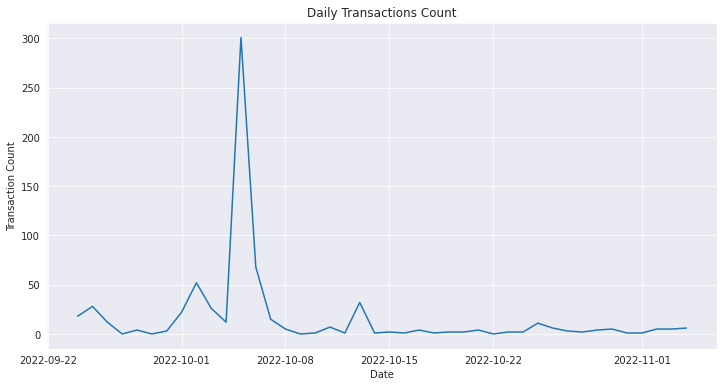

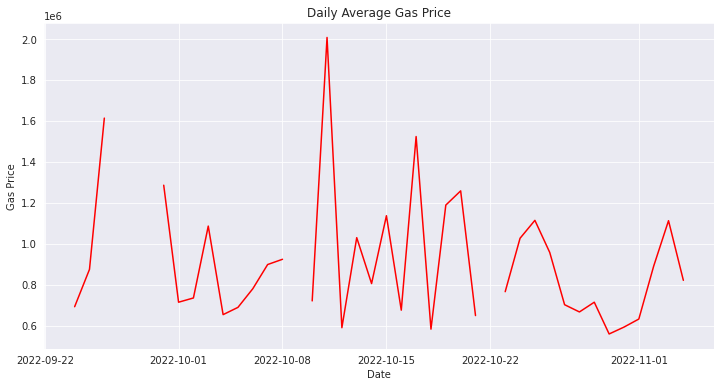

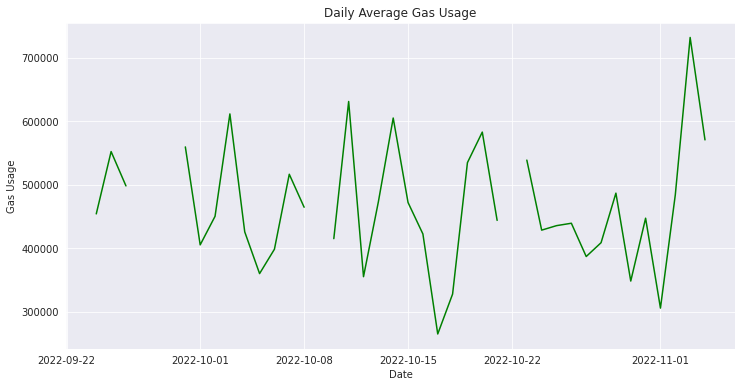

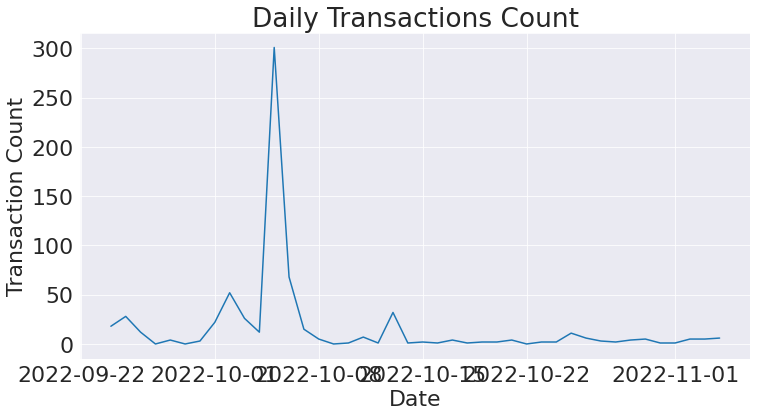

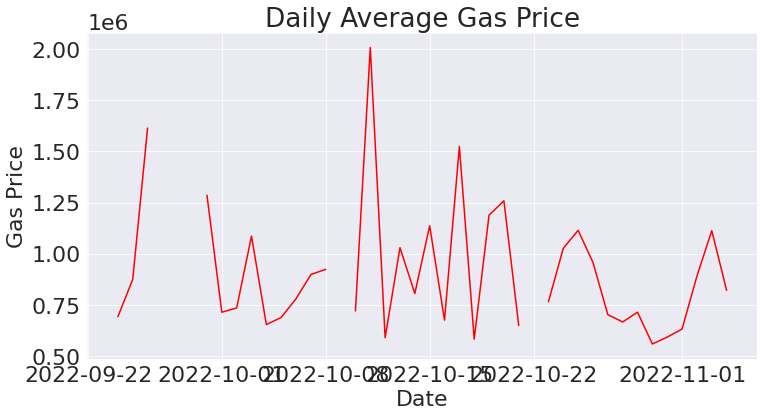

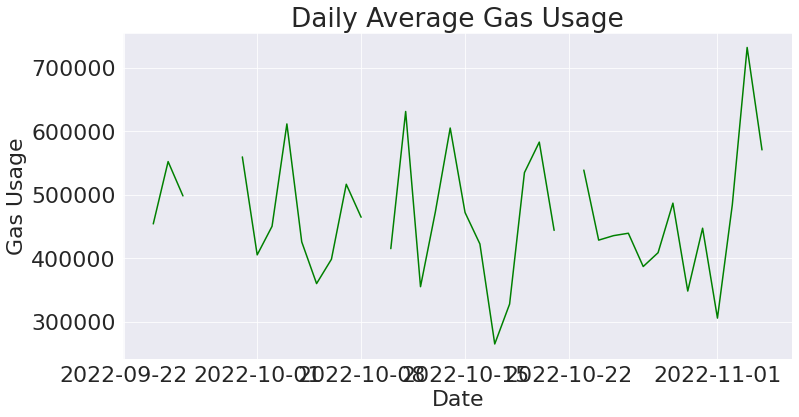

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['transaction_hash', 'count'])
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transactions Count')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_price', 'mean'], color='red')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Daily Average Gas Price')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_usage', 'mean'], color='green')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.title('Daily Average Gas Usage')

plt.show()

## Time-Series Analysis of Accounts

In [72]:
def plot_address_activity(_address, color, _column):
    address_mask = timed_arb_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_arb_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='D')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)
    max_tx_count = daily_tx_count['transaction_hash'].max()
    max_tx_date = daily_tx_count['transaction_hash'].idxmax().strftime('%Y-%m-%d')
    print(f"{_address}: {max_tx_date}, {max_tx_count}")

0xd911560979b78821d7b045c79e36e9cbfc2f6c6f: 2022-10-05, 280
0x807c7f4a42530224d0cf58bb5aea0a3a23591f64: 2022-10-02, 35
0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832: 2022-09-25, 11
0xb206ebe579be55f5b57119bb2e7cc63708eda1aa: 2022-10-06, 16
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8: 2022-10-02, 8


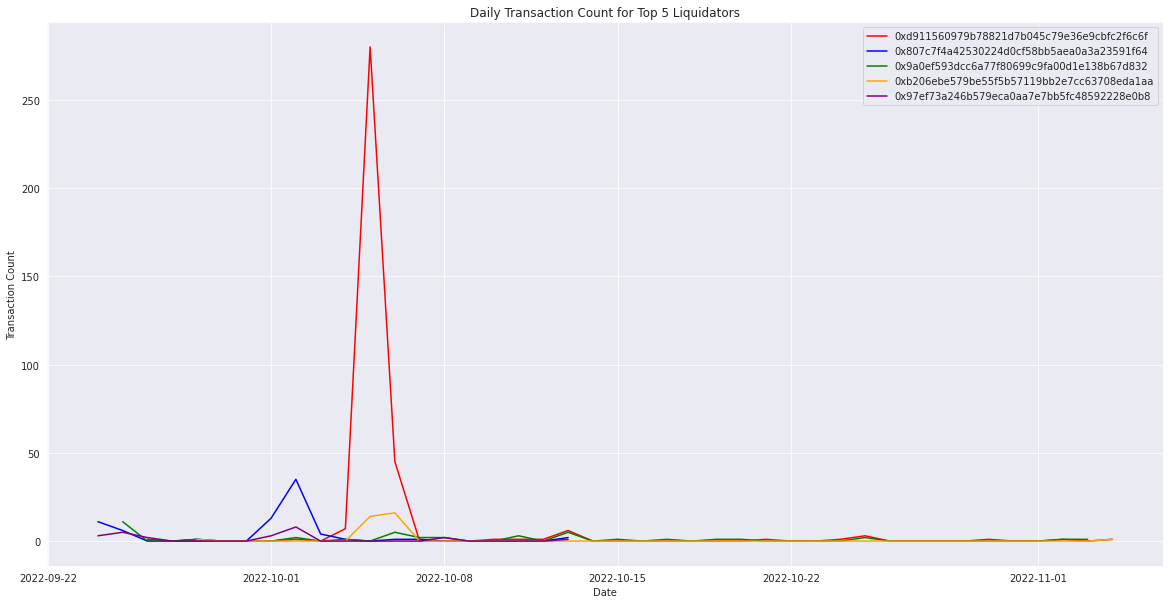

0xd911560979b78821d7b045c79e36e9cbfc2f6c6f: 2022-10-05, 280
0x807c7f4a42530224d0cf58bb5aea0a3a23591f64: 2022-10-02, 35
0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832: 2022-09-25, 11
0xb206ebe579be55f5b57119bb2e7cc63708eda1aa: 2022-10-06, 16
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8: 2022-10-02, 8


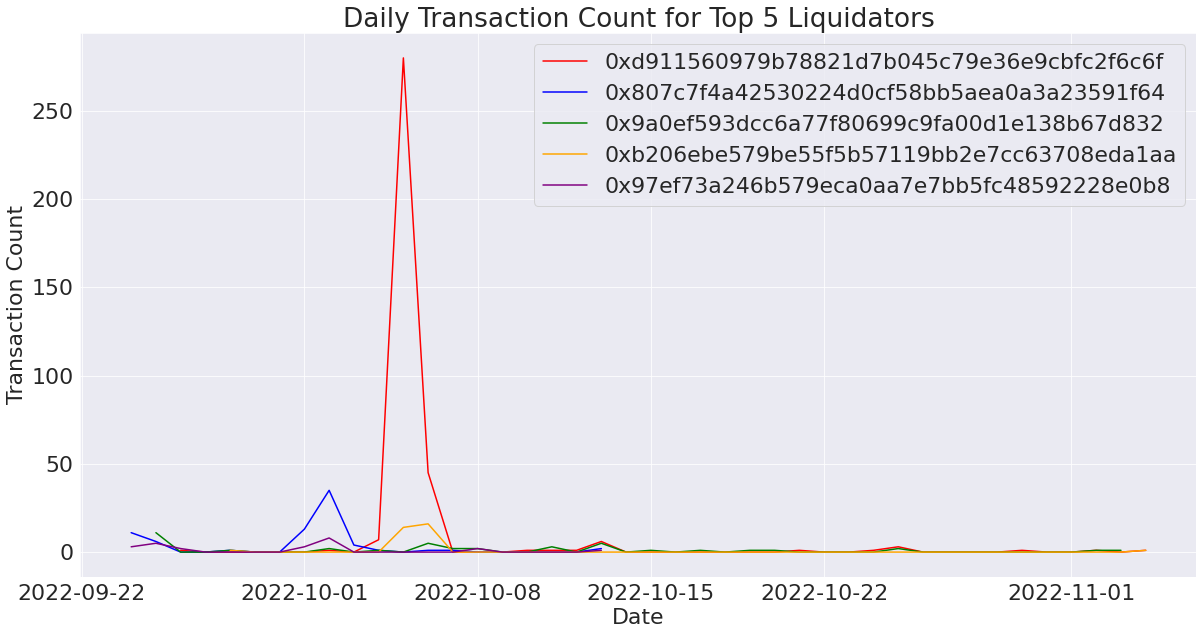

In [73]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20,10))
for i, account_address in enumerate(top_addresses.head(5).index):
    plot_address_activity(_address=account_address, color=colors[i], _column='liquidator_user')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Liquidators')
plt.legend(top_addresses.head(5).index, loc='best')
plt.show()

## Time-Series Analysis of Tokens

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: TokenMintERC20Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Basic Attention: BAT Token
INFO:root:Already found: 1inch Network: 1INCH Token
INFO:root:Already found: TrueUSD: TUSD Token
INFO:root:Already found: Uniswap Protocol: UNI token
INFO:root:Already found: Fei Protocol: FEI Token
INFO:root:Already found: Binance USD
INFO:root:Already found: Maker Token
INFO:root:Already found: Synthetix: Proxy sUSD Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Sai Stablecoin
INFO:root:Already found: AnyswapV5ERC20
INFO:root:Already found: 0x: ZRX Token
INFO:root:Already found: Frax Finance: FRAX Token
0x6b175474e89094c44da98b954eedeac495271d0f: 2022-10-05, 109
0xa0b86991c6218b36c1d19d4a2e9eb0

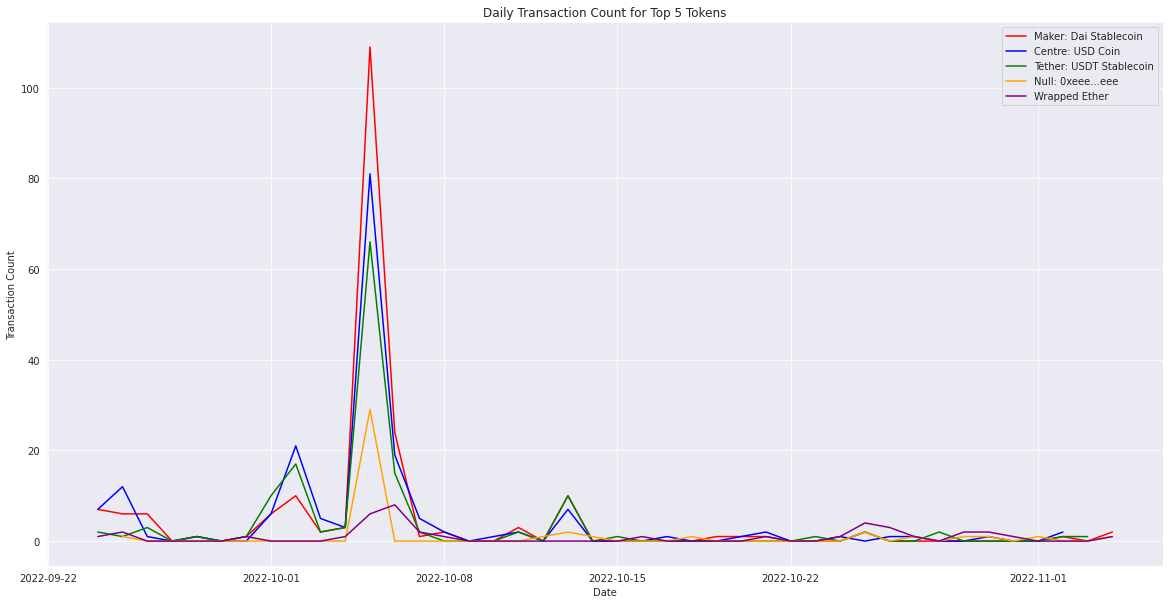

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: TokenMintERC20Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Basic Attention: BAT Token
INFO:root:Already found: 1inch Network: 1INCH Token
INFO:root:Already found: TrueUSD: TUSD Token
INFO:root:Already found: Uniswap Protocol: UNI token
INFO:root:Already found: Fei Protocol: FEI Token
INFO:root:Already found: Binance USD
INFO:root:Already found: Maker Token
INFO:root:Already found: Synthetix: Proxy sUSD Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Sai Stablecoin
INFO:root:Already found: AnyswapV5ERC20
INFO:root:Already found: 0x: ZRX Token
INFO:root:Already found: Frax Finance: FRAX Token
0x6b175474e89094c44da98b954eedeac495271d0f: 2022-10-05, 109
0xa0b86991c6218b36c1d19d4a2e9eb0

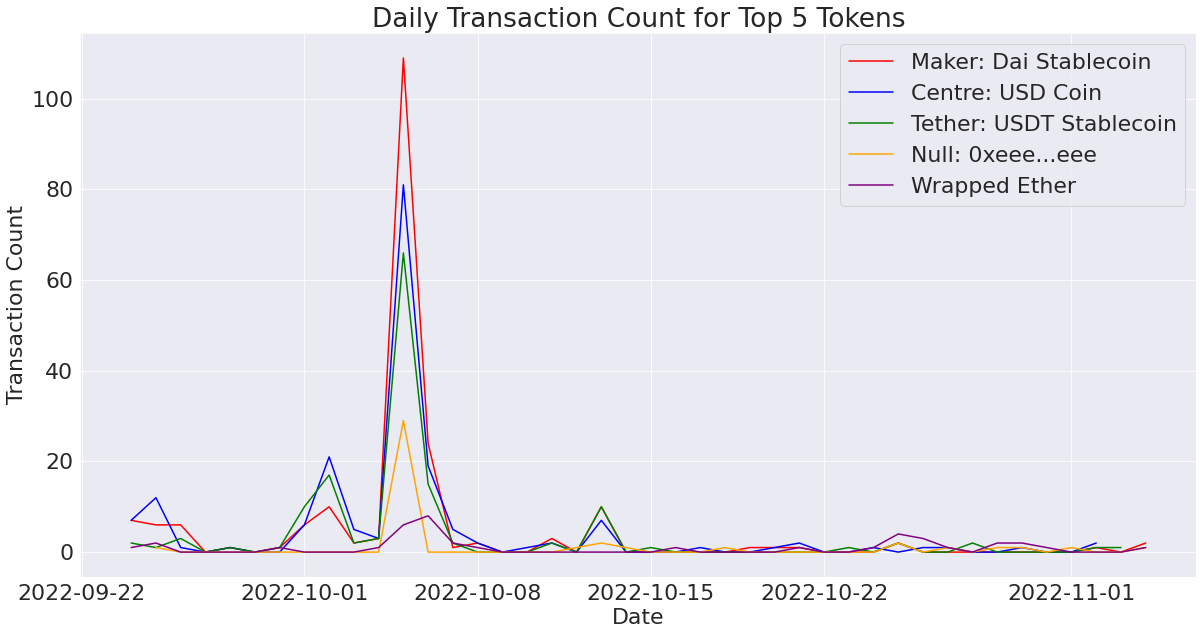

In [74]:
def plot_tokens_tx_cnt(tokens, _column):
    most_used_tokens = tokens.nlargest(20, tokens.columns[0])
    token_name_tags = _get_name_tags(most_used_tokens.index)

    plt.figure(figsize=(20,10))
    for i, token_address in enumerate(most_used_tokens.head(5).index):
        plot_address_activity(_address=token_address, color=colors[i], _column=_column)

    plt.xlabel('Date')
    plt.ylabel('Transaction Count')
    plt.title('Daily Transaction Count for Top 5 Tokens')
    plt.legend(most_used_tokens.index.map(token_name_tags), loc='best')
    plt.show()

plot_tokens_tx_cnt(debt_tokens, 'debt_token_address')

INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Aave: aWETH Token V2
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Aave: aAAVE Token V2
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Compound: cUSDC Token
INFO:root:Already found: Aave: aLINK Token V2
INFO:root:Already found: Compound: cBAT Token
INFO:root:Already found: Compound: cZRX Token
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Compound: cDAI Token
INFO:root:Already found: Lido: stETH Token
INFO:root:Already found: Compound: cWBTC2 Token
INFO:root:Already found: Kyber: Old KNC Token
INFO:root:Already found: Compound: cUNI Token
INFO:root:Already found: Decentraland: MANA Token
INFO:root:Already found: Compound: cWBTC Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Aave: aUNI Token V2
0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5: 2022-10-05, 159
0xc02aaa39b223fe8d0a0e5c

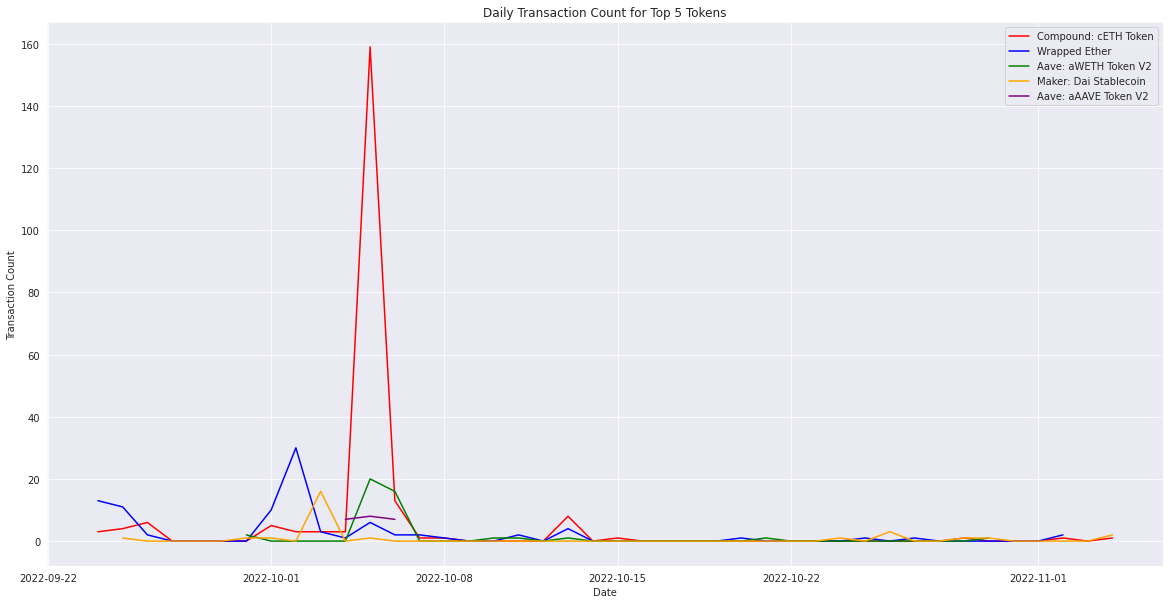

INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Aave: aWETH Token V2
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Aave: aAAVE Token V2
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Compound: cUSDC Token
INFO:root:Already found: Aave: aLINK Token V2
INFO:root:Already found: Compound: cBAT Token
INFO:root:Already found: Compound: cZRX Token
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Compound: cDAI Token
INFO:root:Already found: Lido: stETH Token
INFO:root:Already found: Compound: cWBTC2 Token
INFO:root:Already found: Kyber: Old KNC Token
INFO:root:Already found: Compound: cUNI Token
INFO:root:Already found: Decentraland: MANA Token
INFO:root:Already found: Compound: cWBTC Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Aave: aUNI Token V2
0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5: 2022-10-05, 159
0xc02aaa39b223fe8d0a0e5c

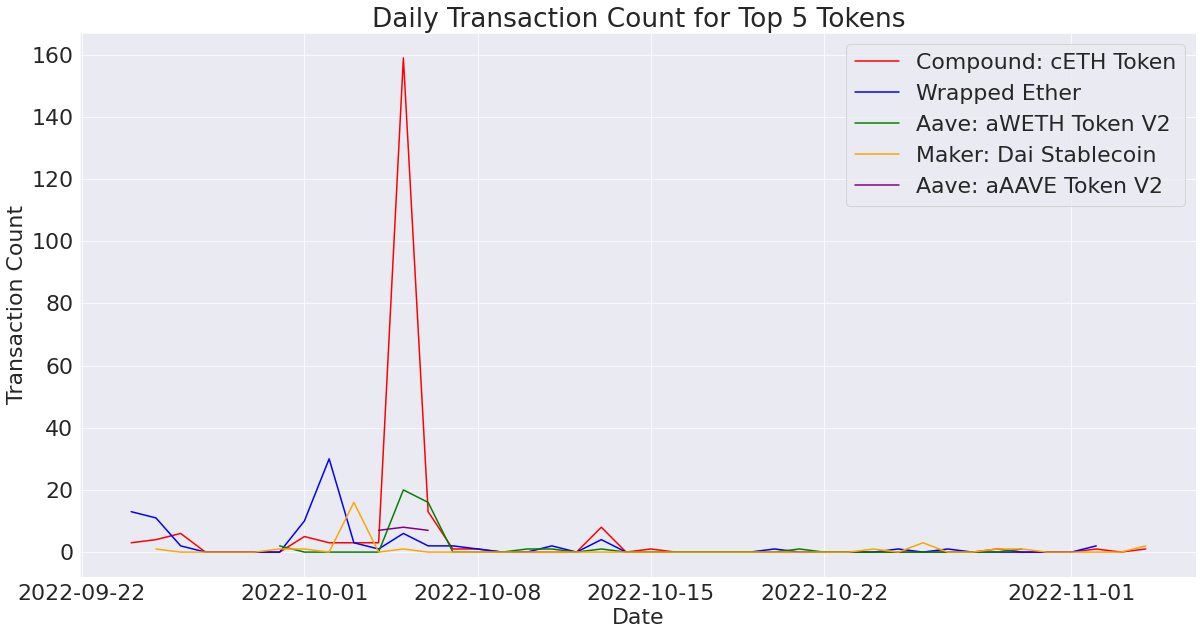

In [75]:
plot_tokens_tx_cnt(received_tokens, "received_token_address")

aave: 2022-10-05, 64
compound_v2: 2022-10-05, 237


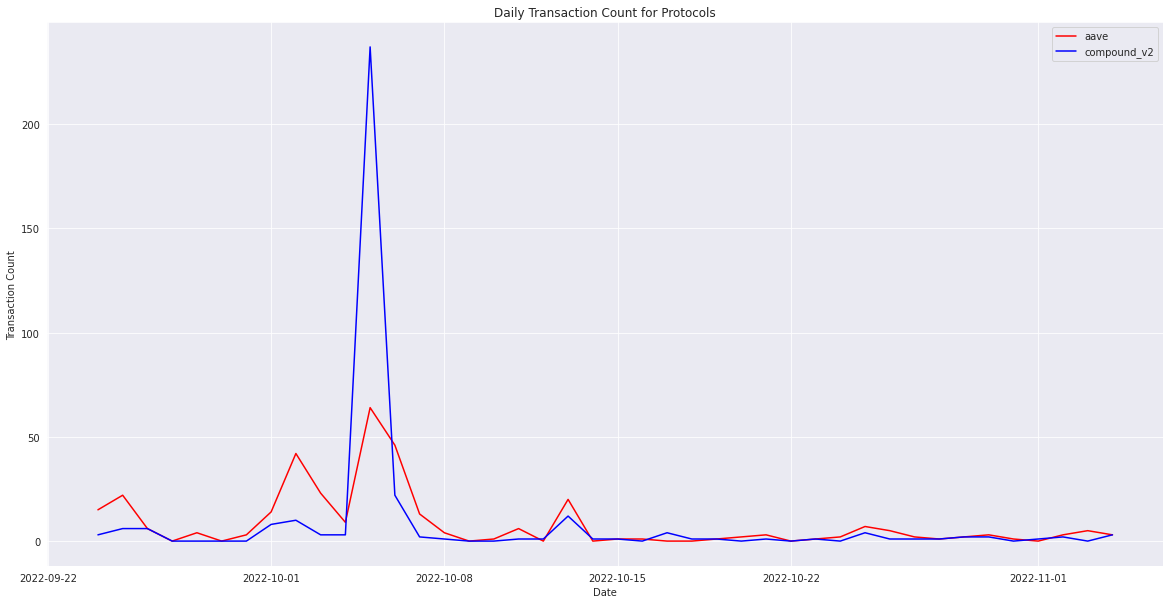

aave: 2022-10-05, 64
compound_v2: 2022-10-05, 237


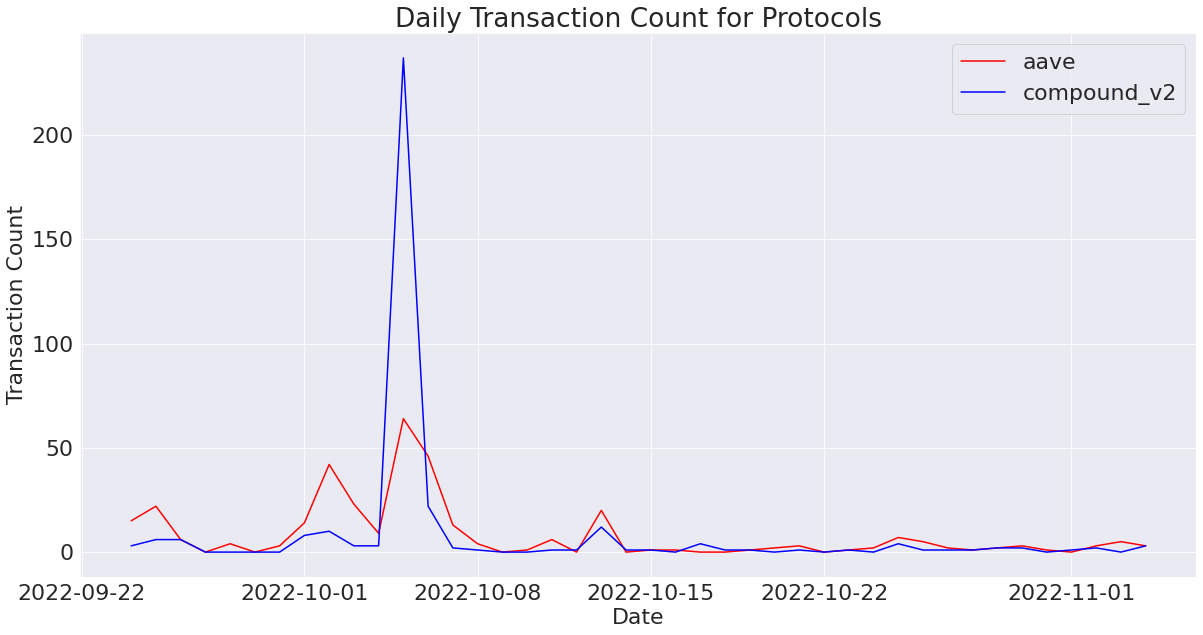

In [76]:
# liquidation_df["protocol"].str.get_dummies()

protocols = liquidation_df['protocol'].reset_index(level=0, drop=True).to_frame('protocol')['protocol'].unique()

plt.figure(figsize=(20,10))
for i, protocol in enumerate(protocols):
    plot_address_activity(_address=protocol, color=colors[i], _column='protocol')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Protocols')
plt.legend(protocols, loc='best')
plt.show()

## Block position

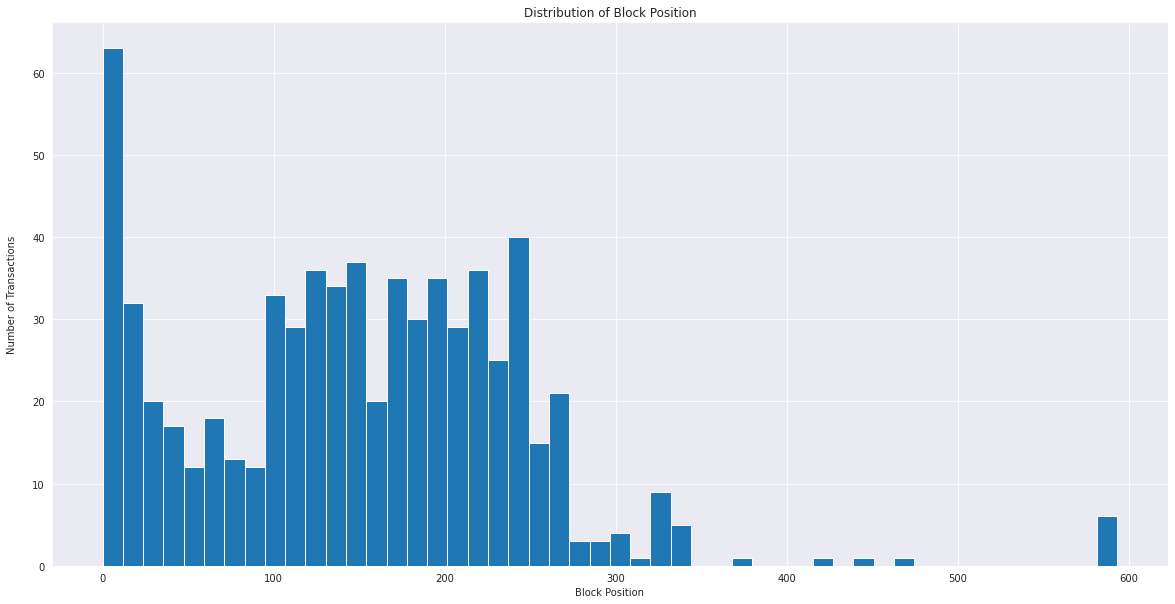

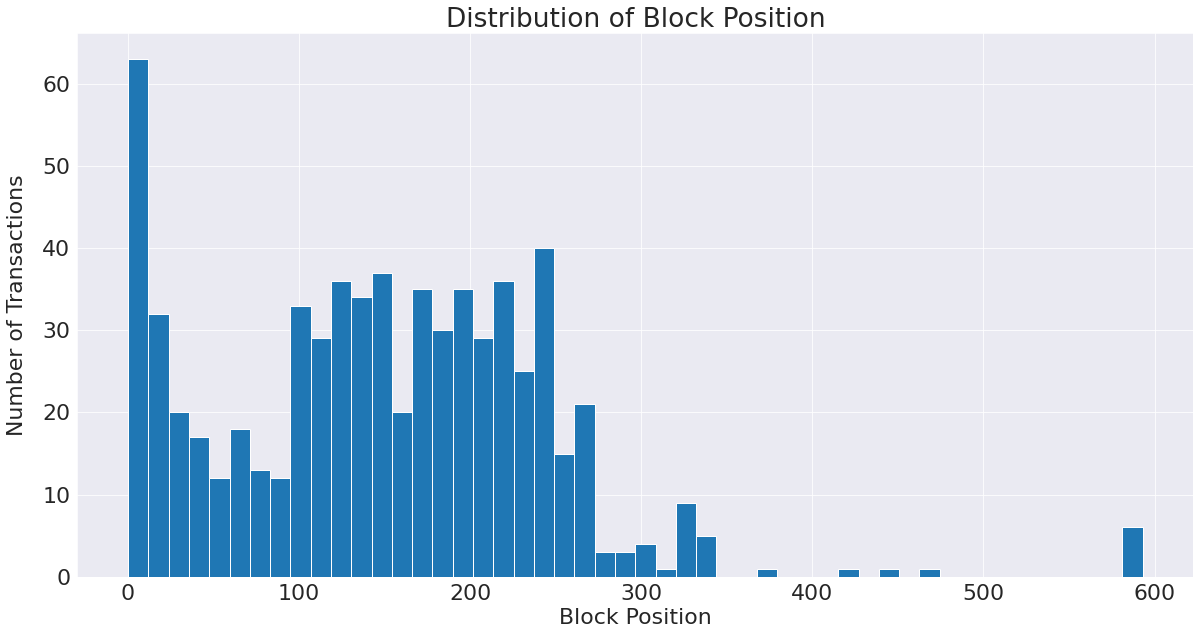

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

liquidation_df['block_position'].hist(bins=50, ax=ax)

ax.set_title('Distribution of Block Position')

ax.set_xlabel('Block Position')
ax.set_ylabel('Number of Transactions', labelpad=15)

plt.show()

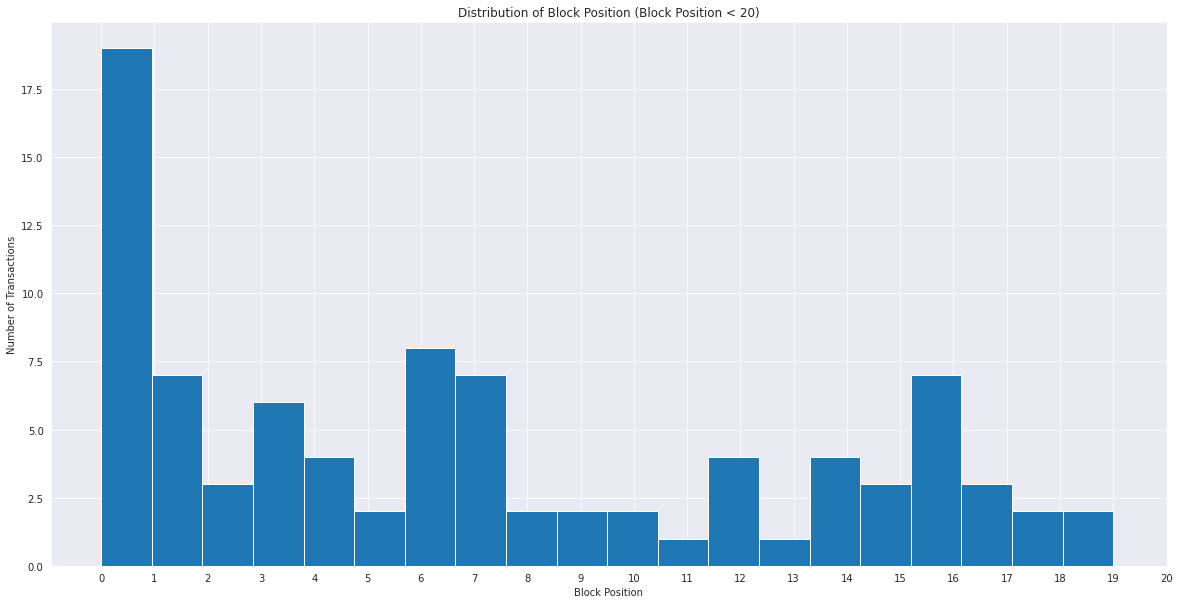

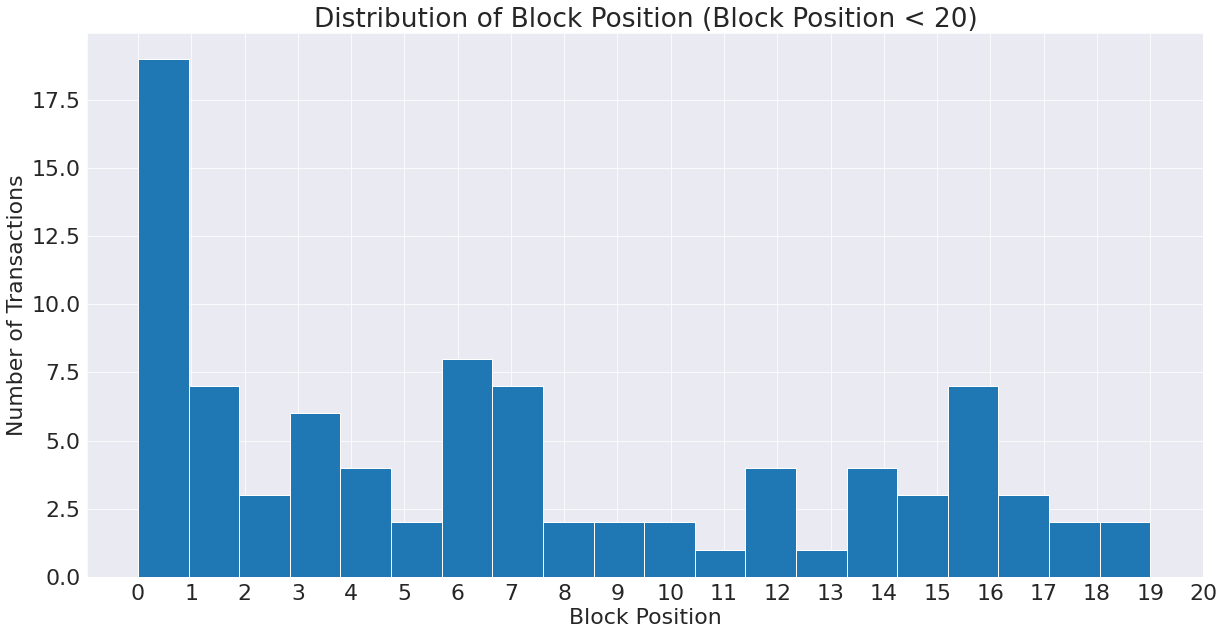

In [78]:
# Filter the data to include only block positions less than 20
filtered_df = liquidation_df[liquidation_df['block_position'] < 20]

# Plot the distribution of block_position less than 20 as a histogram
plt.figure(figsize=(20,10))
filtered_df['block_position'].hist(bins=20)
plt.title('Distribution of Block Position (Block Position < 20)')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.xticks(np.arange(21))
plt.show()

## Protocols

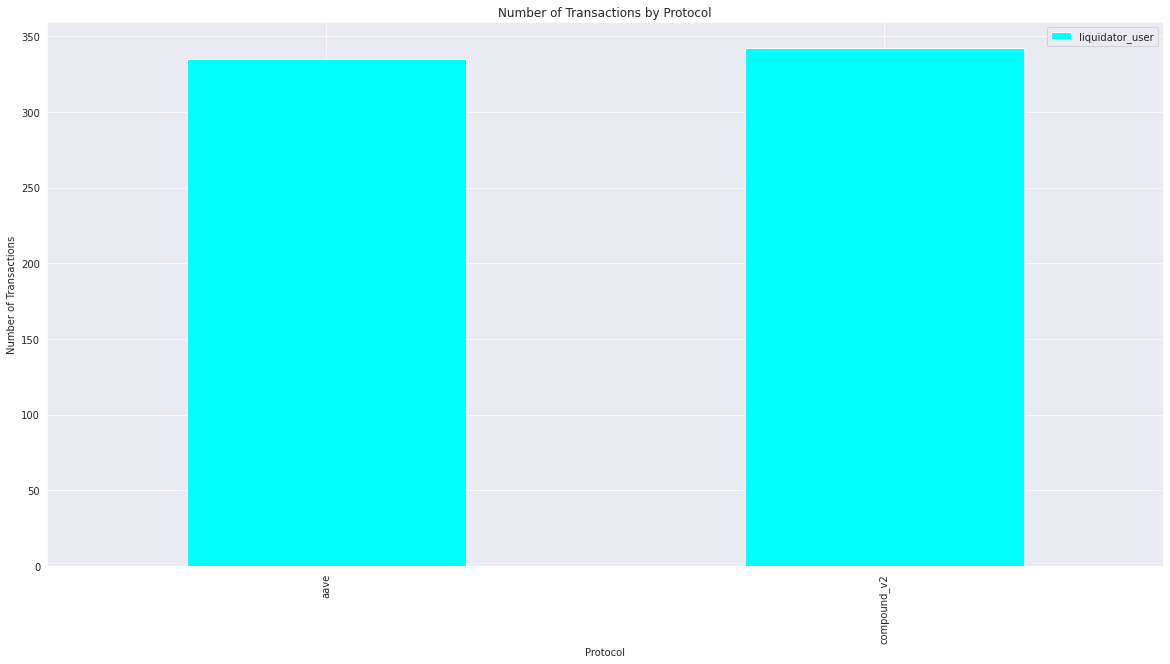

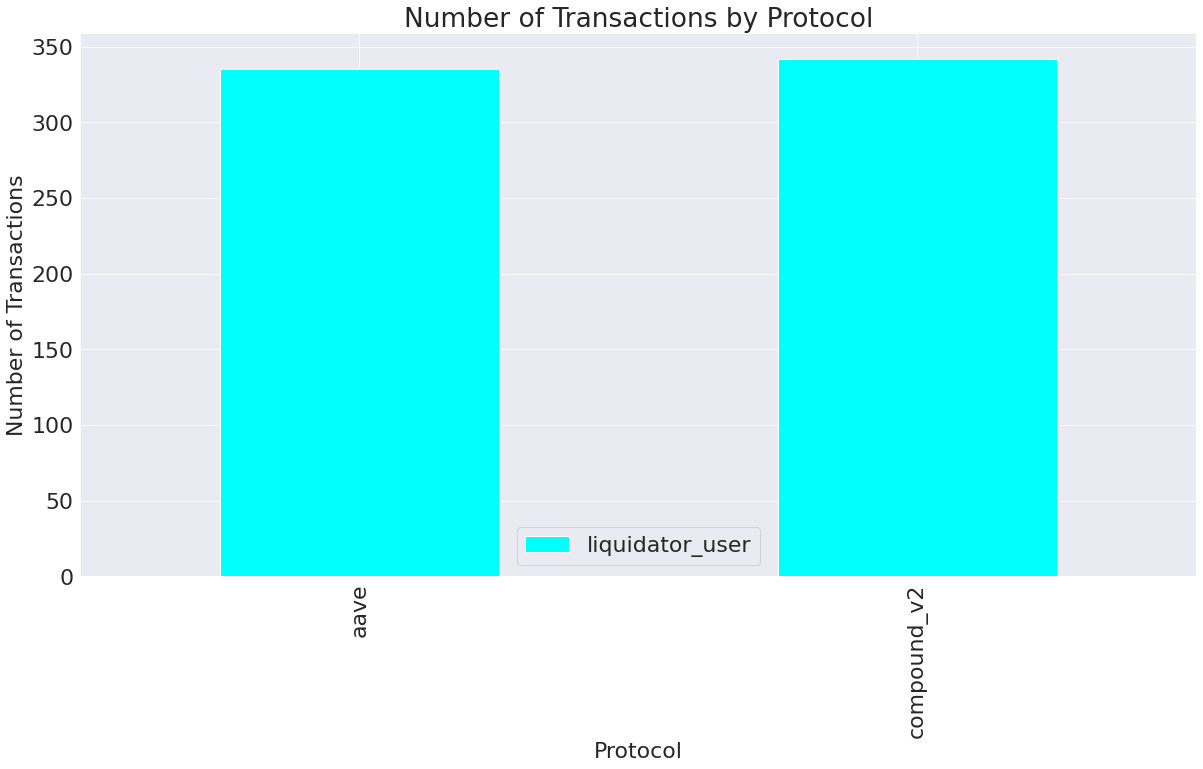

In [79]:
# Parse the protocols column and group by protocol
protocols_df = liquidation_df['protocol'].reset_index(level=0, drop=True).to_frame('protocol')
protocols_df = protocols_df.join(liquidation_df['liquidator_user'].reset_index(level=0, drop=True).to_frame('liquidator_user'))
protocols_df = protocols_df.groupby(['protocol']).count().reset_index()

# Set the figure size and plot the results as a bar chart
_, ax = plt.subplots(figsize=(20, 10))
protocols_df.plot(x='protocol', y='liquidator_user', kind='bar', color='cyan', ax=ax)
plt.title('Number of Transactions by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Transactions')
plt.show()

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin


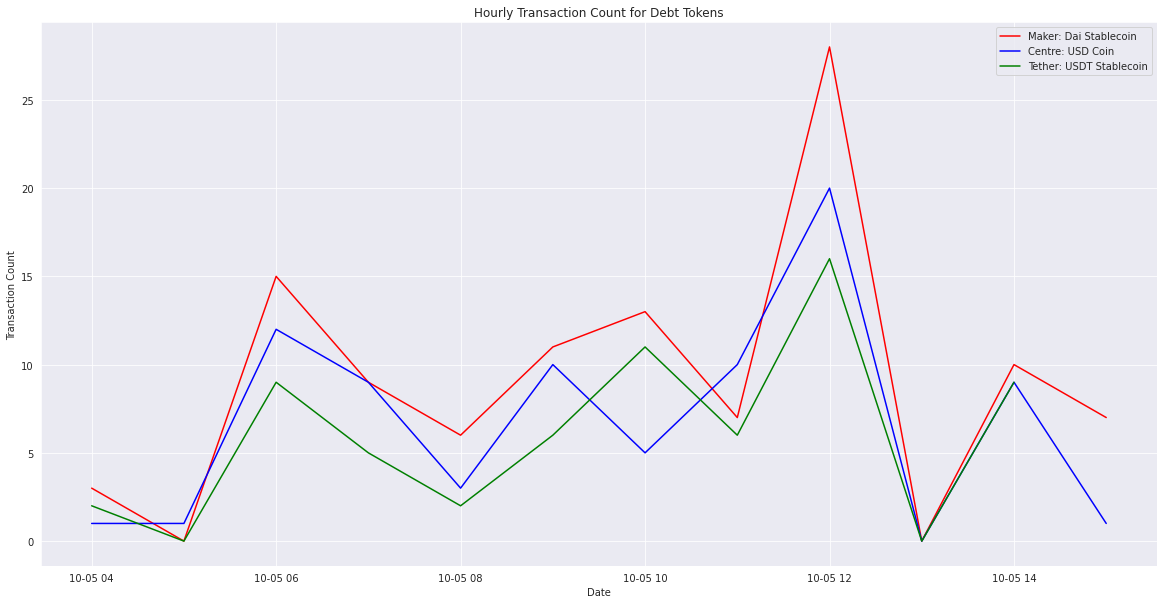

INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin


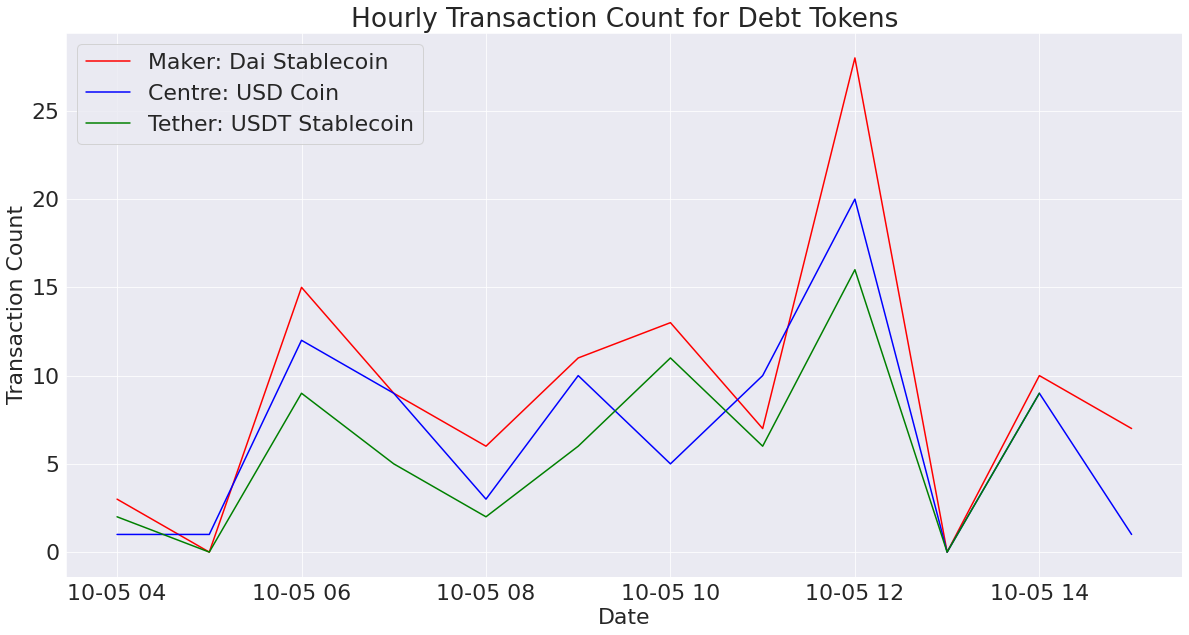

In [80]:
liquidation_df['date'] = liquidation_df['timestamp'].dt.date  # extract date part

# filter for desired date
target_date = pd.to_datetime('2022-10-05').date()  # convert to date format
liquidations_on_target_date = liquidation_df[(liquidation_df['date'] == target_date)]
timed_liq_df = liquidations_on_target_date.set_index('timestamp', inplace=False)


def plot_hourly_address_activity(_address, color, _column):
    address_mask = timed_liq_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_liq_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='H')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)


plt.figure(figsize=(20, 10))
for i, token in enumerate(liquidations_on_target_date['debt_token_address'].value_counts()[:3].index):
    plot_hourly_address_activity(_address=token, color=colors[i], _column='debt_token_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Hourly Transaction Count for Debt Tokens')
tokens_names = _get_name_tags(liquidations_on_target_date['debt_token_address'].value_counts()[:3].index)
plt.legend(tokens_names.values(), loc='best')
plt.show()